# Code for testing the vignette pipeline #

### Step 1: Setup ###

In [11]:
import os
import sys
import json
from pathlib import Path
import open3d as o3d
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# get the root for importing test data
os.environ["SAM_BACKEND"] = "coreml"
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import pipeline modules
from pipeline import segmentation, pointcloud

scikit-learn version 1.7.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.5.1. Disabling scikit-learn conversion API.
Torch version 2.8.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


In [4]:
# Configuration
VIGNETTE_NAME = "capture2"
VIGNETTE_PATH = project_root / "test_data" / VIGNETTE_NAME
print(f"Project Root: {project_root}")
print(f"Testing Vignette: {VIGNETTE_PATH}")

Project Root: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer
Testing Vignette: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2


In [5]:
# Paths for the inputs and outputs
rgb_path = VIGNETTE_PATH / "rgb.png"
metadata_path = VIGNETTE_PATH / "metadata.json"
results_path = VIGNETTE_PATH / "results"

In [6]:
# Open3d display helper
def display_geometries(geometries: list, window_name: str = "Open3D"):
    # Create a Visualizer object
    vis = o3d.visualization.Visualizer()
    # Create the window with a custom name
    vis.create_window(window_name=window_name)
    # Add each geometry to the visualizer
    for geometry in geometries:
        vis.add_geometry(geometry)  
    # Run the visualizer
    vis.run()
    # Destroy it after close
    vis.destroy_window()
    vis.close()
    del vis

### Step 2: SAM Segmentation ###

In [9]:
# UV for testing
uv_coords = [0.5, 0.5]

# Run SAM to get raw logits
logits_path = segmentation.generate_sam_logits(
    rgb_image_path=rgb_path,
    uv_coords=uv_coords,
    output_path=results_path
)
print(f"Logits generated and saved to: {logits_path}")

[sam2] Loading CoreML SAM2 models…
[sam2] Saved CoreML SAM2 logits: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask_logits.npy shape=(1440, 1920)
Logits generated and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask_logits.npy


[sam] Wrote mask: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask.png
Mask created and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask.png


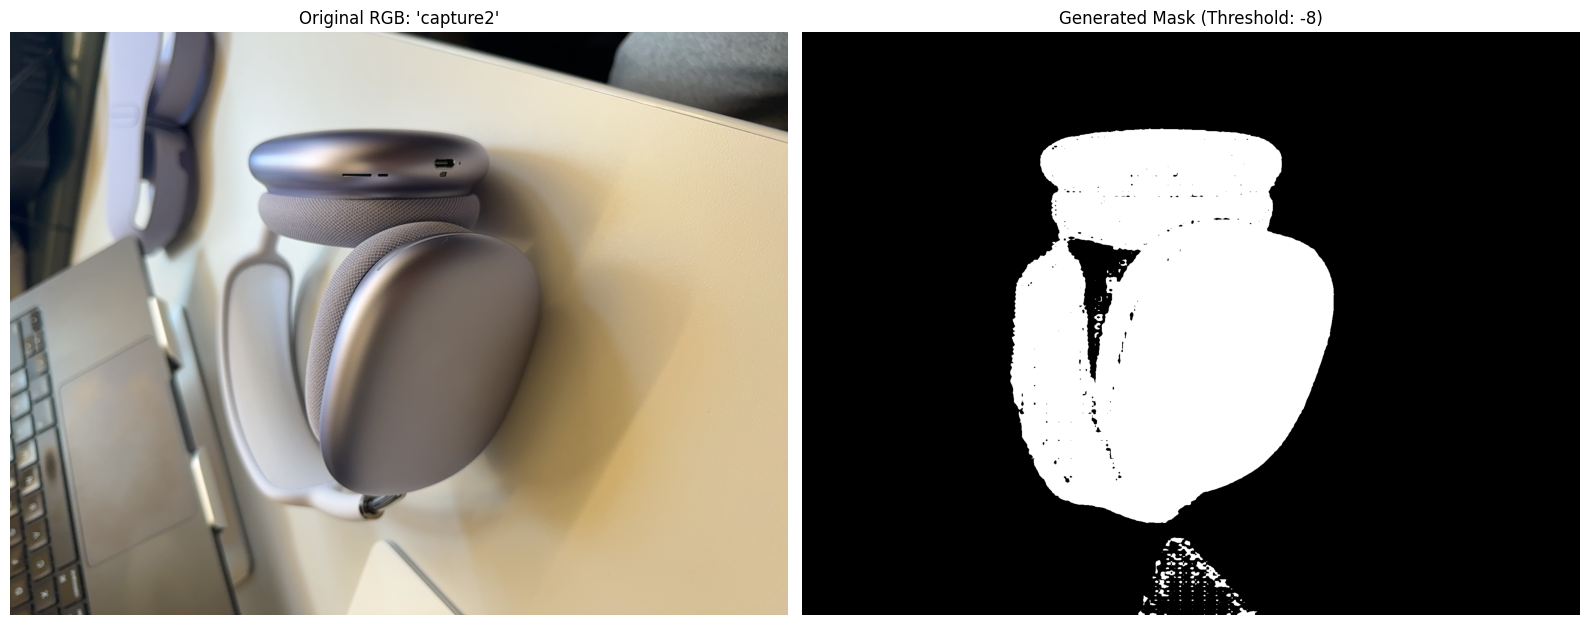

In [18]:
sam_threshold = -8
# Apply the threshold
mask_path = segmentation.apply_threshold_to_logits(
    logits_path=logits_path,
    threshold=sam_threshold,
    output_path=results_path
)
print(f"Mask created and saved to: {mask_path}")

# Display
rgb_image = Image.open(rgb_path)
mask_image = Image.open(mask_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original RGB: '{VIGNETTE_NAME}'")
axes[0].axis('off')

axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title(f"Generated Mask (Threshold: {sam_threshold})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3: Generate Point Cloud ###

In [6]:
# get point cloud
vignette_path = pointcloud.create_masked_point_cloud(VIGNETTE_PATH)

Processing point cloud for: capture2
Generated and centered point cloud with 10312 points.
Set/updated per-point attribute: 'confidence'.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/raw_vignette.npz


In [7]:
vignette_path = results_path / "raw_vignette.npz"
 
# Load the points as a processed vignette
from pipeline.vignette_data import ProcessedVignette
raw_vignette = ProcessedVignette.load(vignette_path)

Set/updated per-point attribute: 'confidence'.
Saved processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/raw_vignette.npz


In [ ]:
# Visualize Colors
pcd_rgb = raw_vignette.to_open3d(color_mode="rgb")
display_geometries([pcd_rgb], window_name="Vignette (RGB Colors)")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [9]:
# Visualize Confidence
pcd_confidence = raw_vignette.to_open3d(color_mode="confidence")
display_geometries([pcd_confidence], window_name="Vignette (Confidence Colors)")

Generating Open3D point cloud with 'confidence' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Step 4: Preprocess Point Cloud ###

In [6]:
from pipeline import preprocessing

processed_vignette = preprocessing.preprocess_vignette(
    raw_vignette=raw_vignette,
    confidence_threshold=1,
    voxel_size=0.001,
    sor_std_ratio=3.0
)

# save it
processed_vignette_path = results_path / "processed_vignette.npz"
processed_vignette.save(processed_vignette_path)

NameError: name 'raw_vignette' is not defined

Generating Open3D point cloud with 'rgb' colors...
Generating Open3D point cloud with 'rgb' colors...


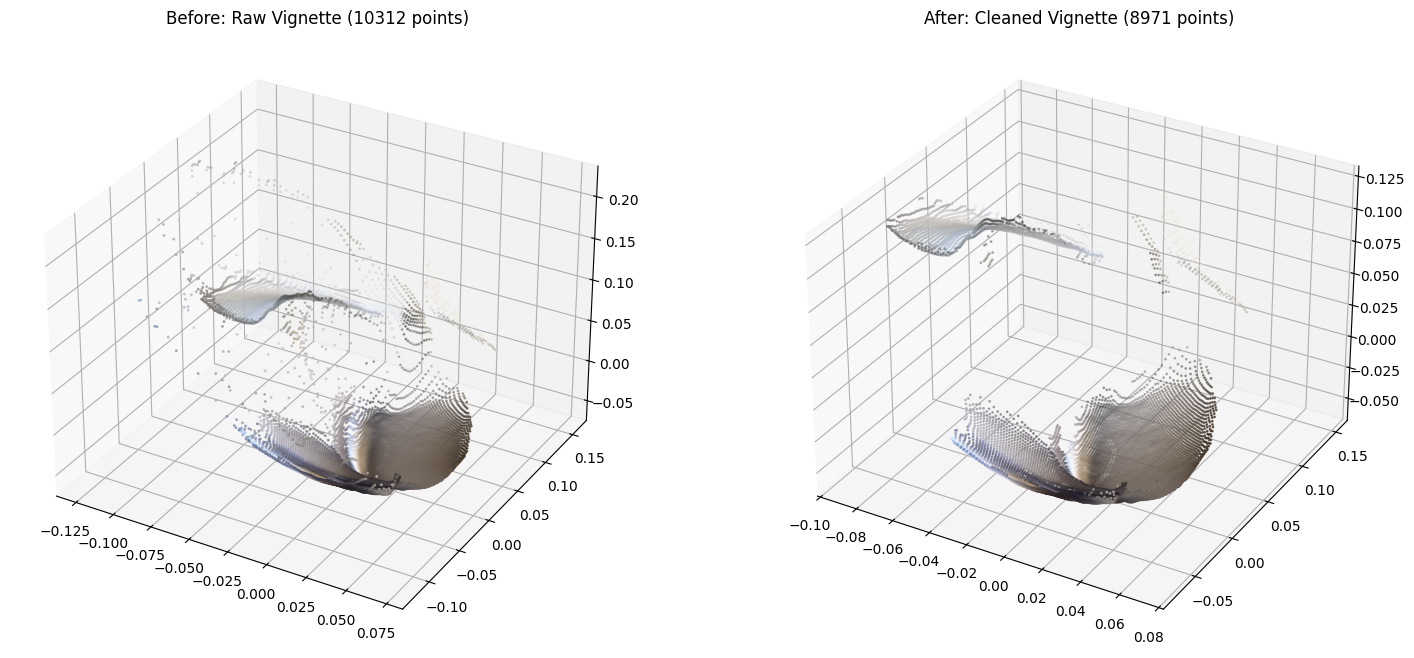

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18, 8))

# Before
ax1 = fig.add_subplot(121, projection='3d')
pcd_raw_viz = raw_vignette.to_open3d().voxel_down_sample(0.001) # Downsample for viz
ax1.scatter(
    np.asarray(pcd_raw_viz.points)[:, 0], np.asarray(pcd_raw_viz.points)[:, 1], np.asarray(pcd_raw_viz.points)[:, 2],
    c=np.asarray(pcd_raw_viz.colors), s=1
)
ax1.set_title(f"Before: Raw Vignette ({len(raw_vignette.points)} points)")
    
# After
ax2 = fig.add_subplot(122, projection='3d')
pcd_clean_viz = processed_vignette.to_open3d()
ax2.scatter(
    np.asarray(pcd_clean_viz.points)[:, 0], np.asarray(pcd_clean_viz.points)[:, 1], np.asarray(pcd_clean_viz.points)[:, 2],
    c=np.asarray(pcd_clean_viz.colors), s=1
)
ax2.set_title(f"After: Cleaned Vignette ({len(processed_vignette.points)} points)")
    
plt.show()

In [24]:
pcd = processed_vignette.to_open3d()
display_geometries([pcd], window_name="Preprocessed Vignette")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Step 5: Abstraction ###

In [7]:
from pipeline import abstraction

# Load preprocessed vignette for tests
processed_vignette_path = results_path / "processed_vignette.npz"
from pipeline.vignette_data import ProcessedVignette
processed_vignette = ProcessedVignette.load(processed_vignette_path)

Set/updated per-point attribute: 'confidence'.
Set/updated per-point attribute: 'plane_id'.
Set/updated per-point attribute: 'cylinder_id'.
Set/updated per-point attribute: 'sphere_id'.
Set/updated per-point attribute: 'cuboid_id'.
Set/updated per-point attribute: 'component_id'.
Saved processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [ ]:
# Save vignette!
processed_vignette.save()

Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


: 

In [9]:
# 01 Dominant Axes
abstraction.extract_dominant_axes(
    processed_vignette,
    cluster_eps=0.04,
    min_cluster_points=50
)
processed_vignette.save()

Extracting dominant axes...
   - Analyzing global axis...
Added new abstraction of type 'axes'.
   - Global axis found with extent: [0.21 0.22 0.09]
   - Clustering components with eps=0.04...
Set/updated per-point attribute: 'component_id'.
   - Found 1 components.
Added new abstraction of type 'axes'.
Finished extracting dominant axes.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [ ]:
# Visualize
pcd_colored_by_component = processed_vignette.to_open3d(color_mode='component_id')
axes_abstractions = processed_vignette.get_abstractions('axes')

'''
print("--- Contents of 'axes' Abstraction ---")
if axes_abstractions:
    # Pretty-print the JSON-like data stored in the metadata
    print(json.dumps(axes_abstractions, indent=2))
else:
    print("No 'axes' abstractions were found in the vignette's metadata.")
    '''

geometries_to_draw = [pcd_colored_by_component]

line_set_points = []
line_set_lines = []
line_set_colors = []
point_index_counter = 0

if axes_abstractions:
    print(f"\nFound {len(axes_abstractions)} axes to visualize.")
    for axis_info in axes_abstractions:
        center = np.array(axis_info['center'])
        
        # --- a) Reconstruct the Bounding Boxes (OBBs) ---
        obb = o3d.geometry.OrientedBoundingBox(
            center=center,
            R=np.array(axis_info['axes']).T,
            extent=axis_info['extent']
        )
        if axis_info.get('type') == 'global':
            obb.color = (1, 0, 0)  # Red
        else:
            obb.color = (0, 1, 0)  # Green
        geometries_to_draw.append(obb)

        # --- b) Build the Axis Lines for the LineSet ---
        axes = axis_info['axes']
        extents = axis_info['extent']
        primary_axis = np.array(axis_info['primary_axis'])

        for i in range(3):
            axis_vector = np.array(axes[i])
            half_extent = extents[i] / 2.0
            
            # Calculate the start and end points of the line segment for this axis
            start_point = center - axis_vector * half_extent
            end_point = center + axis_vector * half_extent
            
            # Add the two points to our list of vertices
            line_set_points.append(start_point)
            line_set_points.append(end_point)
            
            # Add the line connection (connecting the last two points we added)
            line_set_lines.append([point_index_counter, point_index_counter + 1])
            point_index_counter += 2
            
            # Color the primary axis magenta and the others cyan
            if np.allclose(axis_vector, primary_axis):
                line_set_colors.append([1, 0, 1]) # Magenta
            else:
                line_set_colors.append([0, 1, 1]) # Cyan

# Create the LineSet object if we have lines to draw
if line_set_points:
    axis_lines = o3d.geometry.LineSet()
    axis_lines.points = o3d.utility.Vector3dVector(line_set_points)
    axis_lines.lines = o3d.utility.Vector2iVector(line_set_lines)
    # The LineSet requires a color for each line, not each point
    axis_lines.colors = o3d.utility.Vector3dVector(line_set_colors)
    geometries_to_draw.append(axis_lines)


# --- Step 3: Visualize Everything Together ---

print("\nDisplaying point cloud, OBBs (green), and axis lines (magenta/cyan)...")
display_geometries(geometries_to_draw, window_name="Dominant Axes")

Generating Open3D point cloud with 'component_id' colors...

Found 2 axes to visualize.

Displaying point cloud, OBBs (green), and axis lines (magenta/cyan)...


KeyboardInterrupt: 

: 

In [13]:
# do everything
abstraction.extract_dominant_planes(
    processed_vignette,
    distance_threshold=0.003,
    min_points_per_plane=300
)
abstraction.extract_dominant_cylinders(
    processed_vignette,
    distance_threshold=0.01,
    min_points_per_cylinder=200
)
abstraction.extract_dominant_spheres(
    processed_vignette,
    distance_threshold=0.002,
    min_points_per_sphere=200
)
abstraction.extract_dominant_cuboids(
    processed_vignette,
    distance_threshold=0.008,
    min_points_per_cuboid=500
)

Extracting dominant planes...
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Set/updated per-point attribute: 'plane_id'.
Finished extracting dominant planes.
Extracting dominant cylinders...
Added new abstraction of type 'cylinders'.
Added new abstraction of type 'cylinders'.


/Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/venv/lib/python3.12/site-packages/pyransac3d/cylinder.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  ma = (P_rot[1, 1] - P_rot[0, 1]) / (P_rot[1, 0] - P_rot[0, 0])
/Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/venv/lib/python3.12/site-packages/pyransac3d/cylinder.py:86: RuntimeWarning: invalid value encountered in scalar subtract
  ma * mb * (P_rot[0, 1] - P_rot[2, 1])
/Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/venv/lib/python3.12/site-packages/pyransac3d/cylinder.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  mb = (P_rot[2, 1] - P_rot[1, 1]) / (P_rot[2, 0] - P_rot[1, 0])
/Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/venv/lib/python3.12/site-packages/pyransac3d/cylinder.py:86: RuntimeWarning: invalid value encountered in scalar add
  ma * mb * (P_rot[0, 1] - P_rot[2, 1])


Added new abstraction of type 'cylinders'.
Set/updated per-point attribute: 'cylinder_id'.
Finished extracting dominant cylinders.
Extracting dominant spheres...
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Set/updated per-point attribute: 'sphere_id'.
Finished extracting dominant spheres.
Extracting dominant cuboids...
Added new abstraction of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Set/updated per-point attribute: 'cuboid_id'.
Finished extracting dominant cuboids.


In [8]:
print("--- Running Plane Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_planes(
    processed_vignette,
    distance_threshold=0.003,
    min_points_per_plane=300
)

# 2. Prepare geometries for visualization
pcd_planes = processed_vignette.to_open3d(color_mode='plane_id')
plane_abstractions = processed_vignette.get_abstractions('planes')
plane_geometries = [pcd_planes]
cmap_accent = cm.get_cmap("Accent")

if plane_abstractions:
    for i, plane_info in enumerate(plane_abstractions):
        if "obb_center" not in plane_info: continue
        
        # Reconstruct the rectangular mesh from the stored OBB properties
        center, rotation, extent = np.array(plane_info['obb_center']), np.array(plane_info['obb_rotation']), np.array(plane_info['obb_extent'])
        axes = [rotation[:, 0], rotation[:, 1], rotation[:, 2]]
        sorted_indices = np.argsort(extent)
        major_axis, minor_axis = axes[sorted_indices[2]], axes[sorted_indices[1]]
        major_half, minor_half = extent[sorted_indices[2]] / 2.0, extent[sorted_indices[1]] / 2.0

        v1 = center + major_axis * major_half + minor_axis * minor_half
        v2 = center - major_axis * major_half + minor_axis * minor_half
        v3 = center - major_axis * major_half - minor_axis * minor_half
        v4 = center + major_axis * major_half - minor_axis * minor_half
        
        vertices = o3d.utility.Vector3dVector([v1, v2, v3, v4])
        triangles = o3d.utility.Vector3iVector([[0, 1, 2], [0, 2, 3], [0, 2, 1], [0, 3, 2]])
        plane_mesh = o3d.geometry.TriangleMesh(vertices, triangles)
        plane_mesh.compute_vertex_normals()
        plane_mesh.paint_uniform_color(cmap_accent(i / len(plane_abstractions))[:3])
        plane_geometries.append(plane_mesh)

# 3. Display the result
display_geometries(plane_geometries, "Dominant Planes Abstraction")

--- Running Plane Extraction and Visualization ---
Extracting dominant planes...
Cleared 8 abstractions of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Set/updated per-point attribute: 'plane_id'.
Finished extracting dominant planes.
Generating Open3D point cloud with 'plane_id' colors...


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_39979/2024092760.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [9]:
print("--- Running Cylinder Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_cylinders(
    processed_vignette,
    distance_threshold=0.01,
    min_points_per_cylinder=200
)

# 2. Prepare geometries for visualization
pcd_cylinders = processed_vignette.to_open3d(color_mode='cylinder_id')
cylinder_abstractions = processed_vignette.get_abstractions('cylinders')
cylinder_geometries = [pcd_cylinders]
cmap_accent = cm.get_cmap("Accent")

if cylinder_abstractions:
    for i, cyl_info in enumerate(cylinder_abstractions):
        # Get the primitive's parameters from the metadata.
        # RANSAC gives a point on the infinite axis, not necessarily the segment center.
        ransac_center = np.array(cyl_info['center'])
        axis = np.array(cyl_info['axis'])
        radius = cyl_info['radius']

        # Get the actual points that belong to this cylinder to find its true bounds.
        inlier_points = processed_vignette.points[cyl_info['point_indices']]
        
        # Project the inlier points onto the cylinder's axis to find the segment's height and center.
        projections = np.dot(inlier_points - ransac_center, axis)
        min_proj, max_proj = np.min(projections), np.max(projections)
        height = max_proj - min_proj
        
        # The true center of the finite cylinder segment is the midpoint of the projections.
        segment_center = ransac_center + axis * ((min_proj + max_proj) / 2.0)
        
        # Create a mesh with the calculated height.
        cylinder_mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=height, resolution=20)
        
        # Robustly calculate the rotation to align the mesh with the cylinder's axis.
        z_axis = np.array([0., 0., 1.])
        axis_norm = axis / np.linalg.norm(axis)
        
        if np.allclose(z_axis, axis_norm):
            rotation_matrix = np.identity(3)
        elif np.allclose(z_axis, -axis_norm):
            rotation_matrix = cylinder_mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
        else:
            rotation_vector = np.cross(z_axis, axis_norm) * np.arccos(np.clip(np.dot(z_axis, axis_norm), -1.0, 1.0))
            rotation_matrix = cylinder_mesh.get_rotation_matrix_from_axis_angle(rotation_vector)
            
        cylinder_mesh.rotate(rotation_matrix, center=[0,0,0])
        
        # Translate to the calculated center of the bounded segment.
        cylinder_mesh.translate(segment_center)

        cylinder_mesh.paint_uniform_color(cmap_accent(i / len(cylinder_abstractions))[:3])
        cylinder_geometries.append(cylinder_mesh)

# 3. Display the result
display_geometries(cylinder_geometries, "Dominant Cylinders Abstraction")


--- Running Cylinder Extraction and Visualization ---
Extracting dominant cylinders...
Cleared 3 abstractions of type 'cylinders'.
Added new abstraction of type 'cylinders'.


/Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/venv/lib/python3.12/site-packages/pyransac3d/cylinder.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  ma = (P_rot[1, 1] - P_rot[0, 1]) / (P_rot[1, 0] - P_rot[0, 0])
/Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/venv/lib/python3.12/site-packages/pyransac3d/cylinder.py:86: RuntimeWarning: invalid value encountered in scalar subtract
  ma * mb * (P_rot[0, 1] - P_rot[2, 1])


Added new abstraction of type 'cylinders'.
Added new abstraction of type 'cylinders'.
Set/updated per-point attribute: 'cylinder_id'.
Finished extracting dominant cylinders.
Generating Open3D point cloud with 'cylinder_id' colors...


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_39979/1752661632.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [10]:
print("--- Running Sphere Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_spheres(
    processed_vignette,
    distance_threshold=0.002,
    min_points_per_sphere=200
)

# 2. Prepare geometries for visualization
pcd_spheres = processed_vignette.to_open3d(color_mode='sphere_id')
sphere_abstractions = processed_vignette.get_abstractions('spheres')
sphere_geometries = [pcd_spheres]
cmap_accent = cm.get_cmap("Accent")

if sphere_abstractions:
    for i, sphere_info in enumerate(sphere_abstractions):
        # For spheres, the RANSAC result is already bounded. We can visualize it directly.
        # The OBB is still useful for analysis but not required for simple visualization.
        center = np.array(sphere_info['center'])
        radius = sphere_info['radius']
        
        sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
        sphere_mesh.translate(center)
        sphere_mesh.paint_uniform_color(cmap_accent(i / len(sphere_abstractions))[:3])
        sphere_geometries.append(sphere_mesh)

# 3. Display the result
display_geometries(sphere_geometries, "Dominant Spheres Abstraction")

--- Running Sphere Extraction and Visualization ---
Extracting dominant spheres...
Cleared 8 abstractions of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Set/updated per-point attribute: 'sphere_id'.
Finished extracting dominant spheres.
Generating Open3D point cloud with 'sphere_id' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_39979/3872829601.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


In [11]:
print("\n--- Running Cuboid Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_cuboids(
    processed_vignette,
    distance_threshold=0.008,
    min_points_per_cuboid=500
)

# 2. Prepare geometries for visualization
pcd_cuboids = processed_vignette.to_open3d(color_mode='cuboid_id')
cuboid_abstractions = processed_vignette.get_abstractions('cuboids')
cuboid_geometries = [pcd_cuboids]
cmap_accent = cm.get_cmap("Accent")

if cuboid_abstractions:
    for i, cuboid_info in enumerate(cuboid_abstractions):
        # pyransac3d's cuboid result is already an OBB, which we store directly.
        center = np.array(cuboid_info['obb_center'])
        rotation = np.array(cuboid_info['obb_rotation'])
        extent = np.array(cuboid_info['obb_extent'])

        # Reconstruct the Open3D OBB object
        obb = o3d.geometry.OrientedBoundingBox(center, rotation, extent)
        
        # Create a mesh from the OBB for visualization
        cuboid_mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obb)
        
        cuboid_mesh.compute_vertex_normals()
        cuboid_mesh.paint_uniform_color(cmap_accent(i / len(cuboid_abstractions))[:3])
        cuboid_geometries.append(cuboid_mesh)
        
# 3. Display the result
display_geometries(cuboid_geometries, "Dominant Cuboids Abstraction")


--- Running Cuboid Extraction and Visualization ---
Extracting dominant cuboids...
Cleared 2 abstractions of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Set/updated per-point attribute: 'cuboid_id'.
Finished extracting dominant cuboids.
Generating Open3D point cloud with 'cuboid_id' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_39979/932242064.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


In [12]:
abstraction.compose_best_fit_abstraction(
    processed_vignette,
    0.01
)

Composing best-fit abstraction...
   - Starting greedy selection. A primitive must explain at least 89 new points.
     + Evaluating Candidate #1: spheres (ID: 1, Score: 4300301.05)
     - Point Count: 3745, Fit Error: 0.0009
     - It has 3745 total points. Of those, 3745 are currently unexplained.
     - ACCEPTED: 3745 >= threshold 89.
     + Evaluating Candidate #2: planes (ID: 1, Score: 2182611.63)
     - Point Count: 2793, Fit Error: 0.0013
     - It has 2793 total points. Of those, 298 are currently unexplained.
     - ACCEPTED: 298 >= threshold 89.
     + Evaluating Candidate #3: cylinders (ID: 1, Score: 1843495.41)
     - Point Count: 7302, Fit Error: 0.0040
     - It has 7302 total points. Of those, 3734 are currently unexplained.
     - ACCEPTED: 3734 >= threshold 89.
     + Evaluating Candidate #4: spheres (ID: 2, Score: 1827003.70)
     - Point Count: 1788, Fit Error: 0.0010
     - It has 1788 total points. Of those, 130 are currently unexplained.
     - ACCEPTED: 130 >= th

In [13]:


print("\n--- Visualizing Best-Fit Composition ---")

# 1. Prepare the main point cloud, colored by the new 'best_fit_id'
pcd_best_fit = processed_vignette.to_open3d(color_mode='best_fit_id')
geometries_to_draw = [pcd_best_fit]

# 2. Get the final list of selected primitives from the metadata
final_composition = processed_vignette.metadata.get('best_fit_composition')
cmap_accent = cm.get_cmap("Accent")

# --- NEW: Debugging Insights Section ---
print("\n--- Best-Fit Composition Analysis ---")
all_candidates = []
candidate_abstractions = processed_vignette.get_abstractions() or {}
for primitive_type, primitives in candidate_abstractions.items():
    # We only care about the primitive types that compose_best_fit looks at
    if primitive_type not in ['planes', 'cylinders', 'spheres', 'cuboids']:
        continue
    for primitive in primitives:
        all_candidates.append({
            "type": primitive_type,
            "id": primitive.get(f"{primitive_type[:-1]}_id"), # e.g., plane_id
            "score": primitive.get('point_count', 0)
        })

if not all_candidates:
    print("No candidate primitives (planes, cylinders, etc.) were found in the vignette.")
else:
    # Sort candidates by score to see the best ones first
    all_candidates.sort(key=lambda p: p['score'], reverse=True)
    print("All candidate primitives found (sorted by score):")
    for cand in all_candidates:
        print(f"  - Type: {cand['type']}, ID: {cand['id']}, Score (Points): {cand['score']}")
    
    # Explain why the composition might be empty
    # This reflects the logic inside `compose_best_fit_abstraction`
    min_coverage_ratio = 0.01 # Default value from the function
    min_points_threshold = int(processed_vignette.n_points * min_coverage_ratio)
    print(f"\nTo be selected, a primitive needed to explain at least {min_points_threshold} new points.")
    
    if not final_composition:
        if all_candidates and all_candidates[0]['score'] < min_points_threshold:
            print("=> REASON: The best candidate's score was too low to meet the threshold.")
        else:
             print("=> REASON: No primitives were selected. This might be because the best candidates overlapped significantly.")

# --- End of Debugging Section ---

# Toggle shapes
if True and final_composition:
    print(f"\nVisualizing {len(final_composition)} primitives from the best-fit composition.")
    
    for i, primitive_info in enumerate(final_composition):
        primitive_type = primitive_info.get('type')
        mesh_color = cmap_accent(i / len(final_composition))[:3]
        
        # --- Dynamically create the correct mesh based on the primitive's type ---

        if primitive_type == 'planes' and "obb_center" in primitive_info:
            center, rotation, extent = np.array(primitive_info['obb_center']), np.array(primitive_info['obb_rotation']), np.array(primitive_info['obb_extent'])
            axes = [rotation[:, 0], rotation[:, 1], rotation[:, 2]]
            sorted_indices = np.argsort(extent)
            major_axis, minor_axis = axes[sorted_indices[2]], axes[sorted_indices[1]]
            major_half, minor_half = extent[sorted_indices[2]] / 2.0, extent[sorted_indices[1]] / 2.0
            v1, v2, v3, v4 = center + major_axis*major_half + minor_axis*minor_half, center - major_axis*major_half + minor_axis*minor_half, center - major_axis*major_half - minor_axis*minor_half, center + major_axis*major_half - minor_axis*minor_half
            vertices = o3d.utility.Vector3dVector([v1, v2, v3, v4])
            triangles = o3d.utility.Vector3iVector([[0, 1, 2], [0, 2, 3], [0, 2, 1], [0, 3, 2]])
            mesh = o3d.geometry.TriangleMesh(vertices, triangles)
        
        elif primitive_type == 'cylinders' and "obb_center" in primitive_info:
            radius, axis = primitive_info['radius'], np.array(primitive_info['axis'])
            inlier_points = processed_vignette.points[primitive_info['point_indices']]
            projections = np.dot(inlier_points - np.array(primitive_info['center']), axis)
            height = np.max(projections) - np.min(projections)
            segment_center = np.array(primitive_info['center']) + axis * (np.min(projections) + np.max(projections)) / 2.0
            mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=height, resolution=20)
            rotation_matrix = mesh.get_rotation_matrix_from_axis_angle(np.cross(np.array([0.,0.,1.]), axis) * np.arccos(np.dot(np.array([0.,0.,1.]), axis)))
            mesh.rotate(rotation_matrix, center=[0,0,0])
            mesh.translate(segment_center)

        elif primitive_type == 'spheres':
            center, radius = np.array(primitive_info['center']), primitive_info['radius']
            mesh = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
            mesh.translate(center)

        elif primitive_type == 'cuboids' and "obb_center" in primitive_info:
            center, rotation, extent = np.array(primitive_info['obb_center']), np.array(primitive_info['obb_rotation']), np.array(primitive_info['obb_extent'])
            obb = o3d.geometry.OrientedBoundingBox(center, rotation, extent)
            mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obb)
        
        else:
            continue # Skip if type is unknown or missing bounds

        mesh.compute_vertex_normals()
        mesh.paint_uniform_color(mesh_color)
        geometries_to_draw.append(mesh)

# 3. Display the final composed scene
display_geometries(geometries_to_draw, "Best-Fit Composition")


--- Visualizing Best-Fit Composition ---
Generating Open3D point cloud with 'best_fit_id' colors...

--- Best-Fit Composition Analysis ---
All candidate primitives found (sorted by score):
  - Type: cylinders, ID: 1, Score (Points): 7302
  - Type: cuboids, ID: 1, Score (Points): 5833
  - Type: spheres, ID: 1, Score (Points): 3745
  - Type: planes, ID: 1, Score (Points): 2793
  - Type: cuboids, ID: 2, Score (Points): 2337
  - Type: spheres, ID: 2, Score (Points): 1788
  - Type: planes, ID: 2, Score (Points): 1410
  - Type: cylinders, ID: 2, Score (Points): 1181
  - Type: planes, ID: 3, Score (Points): 1112
  - Type: planes, ID: 4, Score (Points): 937
  - Type: spheres, ID: 3, Score (Points): 861
  - Type: planes, ID: 5, Score (Points): 728
  - Type: spheres, ID: 4, Score (Points): 621
  - Type: cuboids, ID: 3, Score (Points): 587
  - Type: planes, ID: 6, Score (Points): 550
  - Type: spheres, ID: 5, Score (Points): 529
  - Type: spheres, ID: 6, Score (Points): 488
  - Type: planes, ID:

/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_39979/2079096612.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Texturing Test ###

In [46]:
# Load preprocessed vignette for tests
processed_vignette_path = results_path / "processed_vignette.npz"
from pipeline.vignette_data import ProcessedVignette
processed_vignette = ProcessedVignette.load(processed_vignette_path)

Set/updated per-point attribute: 'confidence'.
Set/updated per-point attribute: 'plane_id'.
Set/updated per-point attribute: 'cylinder_id'.
Set/updated per-point attribute: 'sphere_id'.
Set/updated per-point attribute: 'cuboid_id'.
Set/updated per-point attribute: 'component_id'.
Set/updated per-point attribute: 'best_fit_id'.
Loaded processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [47]:
from pipeline import texturing
from open3d.visualization import rendering

'''
texturing.create_textured_planes(
    processed_vignette,
    rgb_image_path=rgb_path,
    output_dir=VIGNETTE_PATH,
    point_radius=10
)
'''

texturing.create_textured_planes(
    processed_vignette,
    rgb_image_path=rgb_path,
    output_dir=VIGNETTE_PATH,
    point_radius=10
)

--- Starting Plane-Driven Textured Plane Creation ---

--- Processing Plane 1 ---
   - Plane residual abs mean/max: 0.1732 / 0.1762
   - Saved texture: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/assets/planes/plane_1_texture.png

--- Processing Plane 2 ---
   - Plane residual abs mean/max: 0.2099 / 0.2129
   - Saved texture: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/assets/planes/plane_2_texture.png

--- Processing Plane 3 ---
   - Plane residual abs mean/max: 0.209 / 0.212
   - Saved texture: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/assets/planes/plane_3_texture.png

--- Processing Plane 4 ---
   - Plane residual abs mean/max: 0.2084 / 0.2117
   - Saved texture: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/assets/planes/plane_4_texture.png

--- Processing Plane 5 ---
   - Plane residual abs mean/max: 0.0583 / 0

In [41]:
# --- UV Debug Saver (no rendering; all planes) --------------------------------
# Assumes these exist in your notebook:
#   VIGNETTE_PATH: pathlib.Path to your vignette folder
#   processed_vignette: your loaded ProcessedVignette instance

import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

# =========================
# Helpers for UV debugging
# =========================
def _draw_cross(draw: ImageDraw.ImageDraw, xy, size=8, width=2):
    x, y = xy
    draw.line((x - size, y, x + size, y), width=width)
    draw.line((x, y - size, x, y + size), width=width)

def _uv_to_px_top_left(u, v, W, H):
    # (0,0) at top-left; v increases downward (image-space)
    return (u * (W - 1), v * (H - 1))

def _uv_to_px_bottom_left(u, v, W, H):
    # (0,0) at bottom-left; v increases upward (GL-style)
    return (u * (W - 1), (1.0 - v) * (H - 1))

def save_uv_debug_images(texture_path: Path, uv_corners, out_dir: Path, plane_id: int):
    """
    Draw the 4 UV corner points over the texture and save two PNGs:
      - *_UV-topLeft.png     (assumes v downward)
      - *_UV-bottomLeft.png  (assumes v upward)
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    img = Image.open(texture_path).convert("RGBA")
    W, H = img.size

    canvases = [
        ("topLeft", _uv_to_px_top_left),
        ("bottomLeft", _uv_to_px_top_left),
    ]

    stroke = 3
    try:
        font = ImageFont.load_default()
    except Exception:
        font = None

    uv_corners = np.asarray(uv_corners, dtype=float).reshape(4, 2)

    for label, uv2px in canvases:
        canvas = img.copy()
        draw = ImageDraw.Draw(canvas)

        # Convert each UV to pixel coordinates
        px = [uv2px(float(u), float(v), W, H) for (u, v) in uv_corners]

        # Connect corners (0->1->2->3->0) and draw crosshairs + labels
        draw.line([*px, px[0]], width=stroke)
        for i, (x, y) in enumerate(px):
            _draw_cross(draw, (x, y), size=8, width=stroke)
            draw.text((x + 6, y + 6), f"{i} ({uv_corners[i,0]:.3f},{uv_corners[i,1]:.3f})", font=font)

        out_path = out_dir / f"{texture_path.stem}_plane{plane_id}_UV-{label}.png"
        canvas.save(out_path)
        print(f"[UV DEBUG] Saved: {out_path}")

# ==================================
# Gather planes and write UV overlays
# ==================================
textured_abstractions = processed_vignette.metadata.get('textured_abstractions', {}).get('planes', [])
uv_debug_dir = (VIGNETTE_PATH / "debug_uvs").resolve()

if not textured_abstractions:
    print("No textured planes found to debug.")
else:
    print(f"Found {len(textured_abstractions)} textured planes. Writing UV debug overlays...")
    saved_count = 0
    skipped_count = 0

    for plane_data in textured_abstractions:
        plane_id = plane_data.get('plane_id', 'unknown')
        # Expecting plane_data['mesh_uvs'] to be 4 corners in [0,1]
        uv_corners = plane_data.get('mesh_uvs', None)
        rel_tex = plane_data.get('texture_path', None)

        if uv_corners is None or rel_tex is None:
            print(f"[SKIP] Plane {plane_id}: missing mesh_uvs or texture_path.")
            skipped_count += 1
            continue

        tex_path = (VIGNETTE_PATH / rel_tex).resolve()
        if not tex_path.exists():
            print(f"[SKIP] Plane {plane_id}: texture not found at {tex_path}")
            skipped_count += 1
            continue

        try:
            save_uv_debug_images(
                texture_path=tex_path,
                uv_corners=np.asarray(uv_corners, dtype=float),
                out_dir=uv_debug_dir,
                plane_id=plane_id
            )
            saved_count += 1
        except Exception as e:
            print(f"[ERROR] Plane {plane_id}: failed to save UV debug: {e}")
            skipped_count += 1

    print(f"\nDone. Planes processed: {len(textured_abstractions)} | Saved: {saved_count} | Skipped: {skipped_count}")
    print("Check your UV overlays in:", uv_debug_dir)
# ------------------------------------------------------------------------------

Found 7 textured planes. Writing UV debug overlays...
[UV DEBUG] Saved: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/debug_uvs/plane_1_texture_plane1_UV-topLeft.png
[UV DEBUG] Saved: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/debug_uvs/plane_1_texture_plane1_UV-bottomLeft.png
[UV DEBUG] Saved: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/debug_uvs/plane_2_texture_plane2_UV-topLeft.png
[UV DEBUG] Saved: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/debug_uvs/plane_2_texture_plane2_UV-bottomLeft.png
[UV DEBUG] Saved: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/debug_uvs/plane_3_texture_plane3_UV-topLeft.png
[UV DEBUG] Saved: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/debug_uvs/plane_3_texture_plane3_UV-bottomLeft.png
[UV DEBUG] Saved: /

In [42]:
# --- Debug visualize a single plane (front + back) with optional v-flip -------
# Assumes:
#   VIGNETTE_PATH: pathlib.Path to your vignette folder
#   processed_vignette: your loaded ProcessedVignette instance

import open3d as o3d
import numpy as np
from pathlib import Path
from open3d.visualization import rendering

# -----------------------------
# Settings
# -----------------------------
debug_plane_id = 5          # <- change as needed
flip_v = True               # <- set True to test v' = 1 - v

# -------------------------------------------------------------------
# Step 1: Pull plane list and find the target plane's data & texture
# -------------------------------------------------------------------
textured_abstractions = processed_vignette.metadata.get('textured_abstractions', {}).get('planes', [])
if not textured_abstractions:
    raise RuntimeError("No textured planes found in processed_vignette.metadata['textured_abstractions']['planes'].")

target_plane = next((p for p in textured_abstractions if p.get('plane_id') == debug_plane_id), None)
if target_plane is None:
    raise RuntimeError(f"Plane with plane_id={debug_plane_id} not found in textured_abstractions.")

# Resolve texture path
rel_tex_path = target_plane.get('texture_path')
if not rel_tex_path:
    raise RuntimeError(f"Plane {debug_plane_id} has no 'texture_path'.")

tex_path = (VIGNETTE_PATH / rel_tex_path).resolve()
if not tex_path.exists():
    raise RuntimeError(f"Texture for plane {debug_plane_id} not found at: {tex_path}")

print(f"[INFO] Visualizing plane {debug_plane_id}")
print(f"[INFO] Using texture: {tex_path}")
print(f"[INFO] flip_v = {flip_v}")

# -------------------------------------------------------------------
# Step 2: Build the plane mesh (front + back) with consistent UVs
# -------------------------------------------------------------------
# We construct a double-sided mesh by:
#   (a) taking the original faces ('front_faces'),
#   (b) creating 'back_faces' with reversed index order (to flip winding),
#   (c) concatenating them -> 'all_faces'.
#
# UVs are assigned PER TRIANGLE CORNER to match the triangle list order.
# We can optionally flip v -> 1 - v across all UVs prior to building triangle_uvs.

# -- 2.1: Positions and faces
vertices_np = np.asarray(target_plane['mesh_vertices'], dtype=float)
front_faces = [list(map(int, f)) for f in target_plane['mesh_faces']]  # [[i,j,k], ...]
back_faces  = [[tri[0], tri[2], tri[1]] for tri in front_faces]        # reverse winding for back
all_faces   = front_faces + back_faces

# Create the Open3D mesh
plane_mesh = o3d.geometry.TriangleMesh(
    o3d.utility.Vector3dVector(vertices_np),
    o3d.utility.Vector3iVector(all_faces),
)

# -- 2.2: UVs (per-vertex or 4-corner fallback)
uvs_raw = np.asarray(target_plane['mesh_uvs'], dtype=float)

if len(uvs_raw) == len(vertices_np):
    # Case A: per-vertex UVs
    per_vertex_uv = uvs_raw.copy()
elif len(uvs_raw) == 4 and len(vertices_np) >= 4:
    # Case B: 4 corners (quad). Map to the first 4 vertices by convention.
    per_vertex_uv = np.zeros((len(vertices_np), 2), dtype=float)
    per_vertex_uv[:4] = uvs_raw
    if len(vertices_np) > 4:
        # For any extra verts, reuse corner 0 to avoid out-of-bounds; adjust as needed.
        per_vertex_uv[4:] = uvs_raw[0]
else:
    raise RuntimeError(
        f"Unsupported 'mesh_uvs' length ({len(uvs_raw)}). "
        f"Expected {len(vertices_np)} (per-vertex) or 4 (quad corners)."
    )

# Optional: flip v
if flip_v:
    per_vertex_uv = per_vertex_uv.copy()
    per_vertex_uv[:, 1] = 1.0 - per_vertex_uv[:, 1]

# Build per-corner triangle UVs in the EXACT order of triangles in 'all_faces'
tri_uv_list = []
for (i, j, k) in all_faces:
    tri_uv_list.extend([per_vertex_uv[i], per_vertex_uv[j], per_vertex_uv[k]])
tri_uvs = np.asarray(tri_uv_list, dtype=float)  # shape: (num_triangles*3, 2)

# Assign to the mesh (front and back use the same UV lookups; no additional flips)
plane_mesh.triangle_uvs = o3d.utility.Vector2dVector(tri_uvs)

# -- 2.3: Normals (so lighting works)
plane_mesh.compute_vertex_normals()

# -------------------------------------------------------------------
# Step 3: Create a material and attach the texture
# -------------------------------------------------------------------
material = rendering.MaterialRecord()
material.shader = "defaultLitTransparency"  # uses albedo texture
material.albedo_img = o3d.io.read_image(str(tex_path))

# NOTE:
# - We duplicated faces to render both sides regardless of back-face culling.
# - If your Open3D version supports double-sided materials, you can avoid duplication.

# -------------------------------------------------------------------
# Step 4: Build the point cloud and highlight this plane’s points
# -------------------------------------------------------------------
print("[INFO] Adding point cloud with highlighted plane points...")
pcd = processed_vignette.to_open3d()

# Ensure colors exist
pts_np = np.asarray(pcd.points)
if pts_np.size == 0:
    print("[WARN] Point cloud is empty.")
colors_np = np.asarray(pcd.colors)
if colors_np.shape[0] != pts_np.shape[0]:
    colors_np = np.ones((pts_np.shape[0], 3), dtype=float)

# Pull indices of points belonging to this plane (from abstractions)
plane_abstractions = processed_vignette.get_abstractions('planes') or []
abs_plane = next((p for p in plane_abstractions if p.get('plane_id') == debug_plane_id), None)

if abs_plane and abs_plane.get('point_indices'):
    idx = np.asarray(abs_plane['point_indices'], dtype=int)
    idx = idx[(idx >= 0) & (idx < colors_np.shape[0])]
    colors_np[idx] = [1.0, 0.0, 0.0]  # red highlight
    print(f"[INFO] Highlighted {len(idx)} points for plane {debug_plane_id}.")
else:
    print(f"[WARN] No point indices found for plane {debug_plane_id} in abstractions.")

pcd.colors = o3d.utility.Vector3dVector(colors_np)

# Simple unlit material for the point cloud
pcd_mat = rendering.MaterialRecord()
pcd_mat.shader = "defaultUnlit"

# -------------------------------------------------------------------
# Step 5: Draw (plane front+back + point cloud)
# -------------------------------------------------------------------
geometries_to_draw = [
    {"name": "point_cloud", "geometry": pcd, "material": pcd_mat},
    {"name": f"plane_{debug_plane_id}", "geometry": plane_mesh, "material": material},
]

print("[INFO] Rendering...")
o3d.visualization.draw(
    geometries_to_draw,
    width=1280,
    height=720,
    show_skybox=False,
    bg_color=(1, 1, 1, 1.0),
)
print("[INFO] Done.")
# ---------------------------------------------------------------------------

[INFO] Visualizing plane 5
[INFO] Using texture: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/assets/planes/plane_5_texture.png
[INFO] flip_v = True
[INFO] Adding point cloud with highlighted plane points...
Generating Open3D point cloud with 'rgb' colors...
[INFO] Highlighted 728 points for plane 5.
[INFO] Rendering...
[INFO] Done.


In [43]:
# --- Render ALL planes (front+back) with transparency (defaultLitTransparency) --
# Assumes:
#   VIGNETTE_PATH: pathlib.Path to your vignette folder
#   processed_vignette: your loaded ProcessedVignette instance

import open3d as o3d
import numpy as np
from pathlib import Path
from open3d.visualization import rendering

# ------------------------------------------------------------------------------
# Settings
# ------------------------------------------------------------------------------
flip_v_gl_to_image = True   # True -> apply v' = 1 - v to reconcile GL(bottom-left) vs image(top-left)
show_point_cloud   = True
window_size        = (1280, 720)
background_rgba    = (1.0, 1.0, 1.0, 1.0)

# ------------------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------------------
def build_double_sided_mesh(vertices_np, faces_ij_k):
    """Duplicate faces with reversed winding to make a double-sided mesh."""
    front_faces = [list(map(int, f)) for f in faces_ij_k]
    back_faces  = [[tri[0], tri[2], tri[1]] for tri in front_faces]
    all_faces   = front_faces + back_faces
    mesh = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(vertices_np.astype(float)),
        o3d.utility.Vector3iVector(all_faces),
    )
    return mesh, all_faces

def assemble_triangle_uvs(all_faces, per_vertex_uv):
    """Build per-corner UVs in triangle order."""
    tri_uv_list = []
    for (i, j, k) in all_faces:
        tri_uv_list.extend([per_vertex_uv[i], per_vertex_uv[j], per_vertex_uv[k]])
    return np.asarray(tri_uv_list, dtype=float)

# ------------------------------------------------------------------------------
# Gather planes
# ------------------------------------------------------------------------------
textured_abstractions = processed_vignette.metadata.get('textured_abstractions', {}).get('planes', [])
if not textured_abstractions:
    raise RuntimeError("No textured planes found.")

# ------------------------------------------------------------------------------
# Build draw list
# ------------------------------------------------------------------------------
geometries_to_draw = []

if show_point_cloud:
    pcd = processed_vignette.to_open3d()
    pts_np = np.asarray(pcd.points)
    cols_np = np.asarray(pcd.colors)
    if pts_np.shape[0] > 0 and cols_np.shape[0] != pts_np.shape[0]:
        pcd.colors = o3d.utility.Vector3dVector(np.ones((pts_np.shape[0], 3), dtype=float))
    pcd_mat = rendering.MaterialRecord()
    pcd_mat.shader = "defaultUnlit"
    geometries_to_draw.append({"name": "point_cloud", "geometry": pcd, "material": pcd_mat})

print(f"[INFO] Found {len(textured_abstractions)} planes. flip_v = {flip_v_gl_to_image}")

for plane_data in textured_abstractions:
    pid = plane_data.get('plane_id', 'unknown')
    try:
        # Geometry
        vertices_np = np.asarray(plane_data['mesh_vertices'], dtype=float)
        faces_ij_k  = plane_data['mesh_faces']
        plane_mesh, all_faces = build_double_sided_mesh(vertices_np, faces_ij_k)

        # UVs
        uvs_raw = np.asarray(plane_data['mesh_uvs'], dtype=float)
        if len(uvs_raw) == len(vertices_np):
            per_vertex_uv = uvs_raw.copy()
        elif len(uvs_raw) == 4 and len(vertices_np) >= 4:
            per_vertex_uv = np.zeros((len(vertices_np), 2), dtype=float)
            per_vertex_uv[:4] = uvs_raw
            if len(vertices_np) > 4:
                per_vertex_uv[4:] = uvs_raw[0]
        else:
            raise RuntimeError(
                f"Unsupported mesh_uvs length {len(uvs_raw)}"
            )

        if flip_v_gl_to_image:
            per_vertex_uv = per_vertex_uv.copy()
            per_vertex_uv[:, 1] = 1.0 - per_vertex_uv[:, 1]

        tri_uvs = assemble_triangle_uvs(all_faces, per_vertex_uv)
        plane_mesh.triangle_uvs = o3d.utility.Vector2dVector(tri_uvs)
        plane_mesh.compute_vertex_normals()

        # Transparent material (default)
        tex_path = (VIGNETTE_PATH / plane_data['texture_path']).resolve()
        mat = rendering.MaterialRecord()
        mat.shader = "defaultLitTransparency"
        mat.albedo_img = o3d.io.read_image(str(tex_path))

        geometries_to_draw.append({
            "name": f"plane_{pid}",
            "geometry": plane_mesh,
            "material": mat
        })
        print(f"[OK] Plane {pid} ready.")
    except Exception as e:
        print(f"[SKIP] Plane {pid}: {e}")

# ------------------------------------------------------------------------------
# Render
# ------------------------------------------------------------------------------
print("[INFO] Rendering all planes with transparency...")
o3d.visualization.draw(
    geometries_to_draw,
    width=window_size[0],
    height=window_size[1],
    show_skybox=False,
    bg_color=background_rgba,
)
print("[INFO] Done.")

Generating Open3D point cloud with 'rgb' colors...
[INFO] Found 7 planes. flip_v = True
[OK] Plane 1 ready.
[OK] Plane 2 ready.
[OK] Plane 3 ready.
[OK] Plane 4 ready.
[OK] Plane 5 ready.
[OK] Plane 6 ready.
[OK] Plane 7 ready.
[INFO] Rendering all planes with transparency...
[INFO] Done.


In [44]:
# --- Debug / Visualization cell for a single plane (Jupyter-ready) ---
# Paste this in a notebook cell. Then call:
# debug_plane(vignette, rgb_image_path, plane_index=0)

import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
# IMPORTANT: Do NOT import seaborn; we keep plain matplotlib as requested.

# ---------- Shared helpers (match your pipeline) ----------

def project_points_to_2d(points_3d: np.ndarray, intrinsics: np.ndarray) -> np.ndarray:
    """
    Standard pinhole projection (no extrinsics): uv = K [X,Y,Z]^T / Z
    points_3d: (N,3) in camera/original coords
    intrinsics: 3x3
    """
    P = intrinsics @ points_3d.T  # 3xN
    d = P[2, :] + 1e-9
    u = P[0, :] / d
    v = P[1, :] / d
    return np.vstack((u, v)).T  # (N,2)

def fit_plane_svd(points_world: np.ndarray):
    """
    Least-squares plane fit: centroid + normal (smallest singular vector).
    Returns (centroid(3,), unit_normal(3,))
    """
    c = points_world.mean(axis=0)
    X = points_world - c
    _, _, vh = np.linalg.svd(X, full_matrices=False)
    n = vh[-1, :]
    n = n / (np.linalg.norm(n) + 1e-12)
    return c, n

def project_point_to_plane(p: np.ndarray, p0: np.ndarray, n: np.ndarray) -> np.ndarray:
    """
    Closest orthogonal projection of p onto plane (p0, n). n must be unit.
    """
    return p - np.dot(p - p0, n) * n

def clamp_point_to_obb_on_plane(p_on_plane: np.ndarray,
                                obb_center_world: np.ndarray,
                                u_axis: np.ndarray, v_axis: np.ndarray,
                                u_half: float, v_half: float) -> np.ndarray:
    """
    Keep point inside the plane's OBB footprint by clamping u/v coordinates.
    u_axis, v_axis: in-plane orthonormal axes; halves are extents/2.
    """
    rel = p_on_plane - obb_center_world
    u = float(np.dot(rel, u_axis))
    v = float(np.dot(rel, v_axis))
    u = np.clip(u, -u_half, u_half)
    v = np.clip(v, -v_half, v_half)
    return obb_center_world + u * u_axis + v * v_axis

def sample_disk_color_rgba(img: Image.Image, uv: np.ndarray, radius: int) -> tuple:
    """
    Average RGBA over a disk centered at uv with given radius (pixels).
    Returns (R,G,B,A); A=0 => no valid sample.
    """
    w, h = img.size
    cx, cy = float(uv[0]), float(uv[1])
    x_min = max(int(np.floor(cx - radius)), 0)
    x_max = min(int(np.ceil (cx + radius)), w - 1)
    y_min = max(int(np.floor(cy - radius)), 0)
    y_max = min(int(np.ceil (cy + radius)), h - 1)
    if x_min > x_max or y_min > y_max:
        return (0, 0, 0, 0)

    crop = img.crop((x_min, y_min, x_max + 1, y_max + 1)).convert("RGBA")
    mask = Image.new("L", crop.size, 0)
    draw = ImageDraw.Draw(mask)
    ccx, ccy = cx - x_min, cy - y_min
    draw.ellipse((ccx - radius, ccy - radius, ccx + radius, ccy + radius), fill=255)

    crop_np = np.asarray(crop, dtype=np.float32)
    mask_np = np.asarray(mask, dtype=np.uint8)
    sel = mask_np > 0
    if not np.any(sel):
        return (0, 0, 0, 0)

    vals = crop_np[sel].reshape(-1, 4)
    mean = vals.mean(axis=0)
    r, g, b, a = [int(np.clip(v, 0, 255)) for v in mean]
    return (r, g, b, 255)  # paint opaque; change if you want soft alpha

# ---------- Main debug function ----------

def debug_plane(vignette, rgb_image_path: str, plane_index: int,
                point_draw_radius: int = 5,
                color_sample_radius: int = 5,
                clamp_to_obb: bool = True,
                z_min: float = 1e-6):
    """
    Visualizes the revised 3-step logic for the i-th plane.
    Produces 4 figures:
      1) 3D: inliers + plane frame (u,v axes) + camera origin
      2) Source image with sampling positions (step 1)
      3) Source image with reprojected positions (step 3)
      4) Final painted texture (what you draw)
    """

    # --- Load metadata / camera ---
    capture_meta = vignette.metadata.get('capture_metadata', {})
    intrinsics = np.array(capture_meta.get('camera_intrinsics', {}).get('columns', np.identity(3))).T
    center_offset = np.array(capture_meta.get('center_offset', [0, 0, 0]))
    if np.array_equal(intrinsics, np.identity(3)) or np.allclose(center_offset, [0, 0, 0]):
        print("WARNING: Missing camera intrinsics or center_offset; projections may be invalid.")

    planes = vignette.get_abstractions('planes')
    if not planes:
        print("No planes available.")
        return
    if not (0 <= plane_index < len(planes)):
        print(f"Plane index {plane_index} out of range 0..{len(planes)-1}")
        return

    plane = planes[plane_index]

    # --- Load image ---
    source_image = Image.open(rgb_image_path).convert("RGBA")
    im_w, im_h = source_image.size

    # --- Pull plane data ---
    if not all(k in plane for k in ['obb_center', 'obb_rotation', 'obb_extent', 'point_indices']):
        print("Plane is missing OBB or inlier indices.")
        return

    pts_centered = vignette.points[plane['point_indices']]
    pts = pts_centered + center_offset  # assume "original" == camera coordinates

    # --- Fit plane robustly and set frame axes from OBB ---
    centroid, n_svd = fit_plane_svd(pts)

    R = np.array(plane['obb_rotation'])
    extent = np.array(plane['obb_extent'])
    axes = [R[:, i] for i in range(3)]
    order = np.argsort(extent)   # 0=thin(normal), 1=minor=v, 2=major=u
    thin_axis = axes[order[0]] / (np.linalg.norm(axes[order[0]]) + 1e-12)
    v_axis    = axes[order[1]] / (np.linalg.norm(axes[order[1]]) + 1e-12)
    u_axis    = axes[order[2]] / (np.linalg.norm(axes[order[2]]) + 1e-12)
    v_half = float(extent[order[1]] / 2.0)
    u_half = float(extent[order[2]] / 2.0)

    # Align fitted normal to OBB thin axis (for consistent orientation)
    if np.dot(n_svd, thin_axis) < 0:
        n_svd = -n_svd

    plane_point = centroid
    obb_center_world = np.array(plane['obb_center']) + center_offset

    # Diagnostics on plane fit
    plane_residuals = np.dot(pts - plane_point, n_svd)
    print(f"[Plane {plane_index}] fit residual abs mean/max: "
          f"{np.mean(np.abs(plane_residuals)):.4g} / {np.max(np.abs(plane_residuals)):.4g}")

    # --- Step 1: project original points to camera plane and sample colors ---
    uv0 = project_points_to_2d(pts, intrinsics)  # (N,2)
    valid_step1 = []
    sampled_colors = []
    for uv in uv0:
        if -10 <= uv[0] <= im_w + 10 and -10 <= uv[1] <= im_h + 10:
            c = sample_disk_color_rgba(source_image, uv, color_sample_radius)
            if c[3] > 0:
                valid_step1.append(uv)
                sampled_colors.append(c)
    valid_step1 = np.array(valid_step1) if len(valid_step1) else np.zeros((0, 2))
    print(f"Step1: valid sampling positions: {valid_step1.shape[0]} / {uv0.shape[0]}")

    # --- Step 2: project to closest point on plane (and clamp to OBB if requested) ---
    p_on_plane_all = []
    for p in pts:
        q = project_point_to_plane(p, plane_point, n_svd)
        if clamp_to_obb:
            q = clamp_point_to_obb_on_plane(q, obb_center_world, u_axis, v_axis, u_half, v_half)
        p_on_plane_all.append(q)
    p_on_plane_all = np.array(p_on_plane_all)  # (N,3)

    # --- Step 3: reproject closest-on-plane points to camera; filter behind camera ---
    uv2_all = project_points_to_2d(p_on_plane_all, intrinsics)
    valid_uv2 = []
    valid_colors = []
    valid_pairs = 0
    for (uv_s, uv_r, q, col) in zip(uv0, uv2_all, p_on_plane_all, sampled_colors + [(0,0,0,0)]*max(0, uv0.shape[0]-len(sampled_colors))):
        if q[2] > z_min:  # simple visibility check in camera coords
            valid_uv2.append(uv_r)
            # NOTE: We only have as many sampled_colors as valid step1 points.
            # To keep pairs aligned, we re-sample color for this point if needed:
            if col == (0,0,0,0):
                col = sample_disk_color_rgba(source_image, uv_s, color_sample_radius)
            valid_colors.append(col)
            valid_pairs += 1
    valid_uv2 = np.array(valid_uv2) if valid_uv2 else np.zeros((0, 2))
    print(f"Step3: valid reprojected positions: {valid_uv2.shape[0]} / {uv2_all.shape[0]}")

    # --- Build the painted texture (final) ---
    canvas = Image.new('RGBA', (im_w, im_h), (0, 0, 0, 0))
    draw = ImageDraw.Draw(canvas)
    for uv_r, col in zip(valid_uv2, valid_colors):
        cx = float(np.clip(uv_r[0], 0, im_w - 1))
        cy = float(np.clip(uv_r[1], 0, im_h - 1))
        draw.ellipse((cx - point_draw_radius, cy - point_draw_radius,
                      cx + point_draw_radius, cy + point_draw_radius), fill=col)

    # ---------- FIGURE 1: 3D view (points + plane frame + camera origin) ----------
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=4, label='Plane Inliers (3D)')
    # Plane frame: draw rectangle outline in 3D using u/v axes from OBB
    corners = np.array([
        obb_center_world + (-u_half)*u_axis + ( v_half)*v_axis,
        obb_center_world + ( u_half)*u_axis + ( v_half)*v_axis,
        obb_center_world + ( u_half)*u_axis + (-v_half)*v_axis,
        obb_center_world + (-u_half)*u_axis + (-v_half)*v_axis,
        obb_center_world + (-u_half)*u_axis + ( v_half)*v_axis,
    ])
    ax.plot(corners[:,0], corners[:,1], corners[:,2], label='Plane OBB perimeter')
    # Camera origin (assumed at (0,0,0) in camera coords)
    ax.scatter([0], [0], [0], marker='^', s=50, label='Camera Origin')
    # Normal arrow at OBB center
    tip = obb_center_world + 0.1 * n_svd * max(u_half, v_half)
    ax.plot([obb_center_world[0], tip[0]],
            [obb_center_world[1], tip[1]],
            [obb_center_world[2], tip[2]],
            label='Plane Normal (fitted)')
    # Aspect
    try:
        ax.set_box_aspect([1,1,1])
    except Exception:
        pass
    ax.set_title(f"Plane {plane_index}: 3D inliers & plane frame")
    ax.legend()
    plt.show()

    # ---------- FIGURE 2: Source image + sampling positions (step 1) ----------
    fig2 = plt.figure()
    plt.imshow(source_image)
    if valid_step1.shape[0] > 0:
        plt.scatter(valid_step1[:, 0], valid_step1[:, 1], s=5, label='Sample positions (Step 1)')
        plt.legend()
    plt.title(f"Plane {plane_index}: Step 1 sampling on source RGB")
    plt.axis('off')
    plt.show()

    # ---------- FIGURE 3: Source image + reprojected positions (step 3) ----------
    fig3 = plt.figure()
    plt.imshow(source_image)
    if valid_uv2.shape[0] > 0:
        plt.scatter(valid_uv2[:, 0], valid_uv2[:, 1], s=5, label='Reprojected positions (Step 3)')
        plt.legend()
    plt.title(f"Plane {plane_index}: Step 3 reprojected positions")
    plt.axis('off')
    plt.show()

    # ---------- FIGURE 4: Final painted texture (what you draw) ----------
    fig4 = plt.figure()
    plt.imshow(canvas)
    plt.title(f"Plane {plane_index}: Final painted texture (dots)")
    plt.axis('off')
    plt.show()

    print("Done. Inspect the figures to verify each stage.")
    return {
        "fitted_plane_point": plane_point,
        "fitted_plane_normal": n_svd,
        "obb_center_world": obb_center_world,
        "u_axis": u_axis, "v_axis": v_axis, "u_half": u_half, "v_half": v_half,
        "uv_sample_positions": uv0,
        "uv_reprojected_positions": uv2_all,
        "canvas_image": canvas  # PIL image, in case you want to save it
    }

[Plane 5] fit residual abs mean/max: 0.001479 / 0.003401
Step1: valid sampling positions: 550 / 550
Step3: valid reprojected positions: 550 / 550


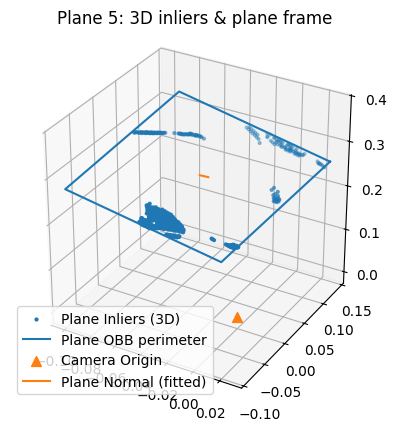

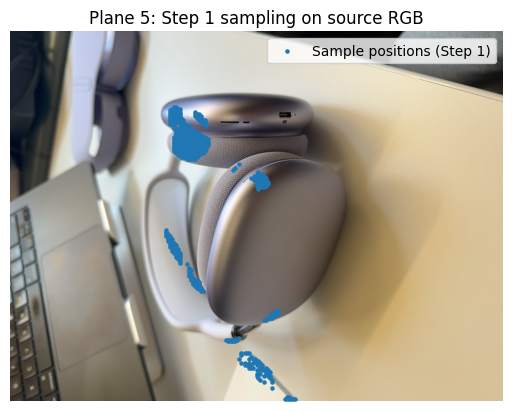

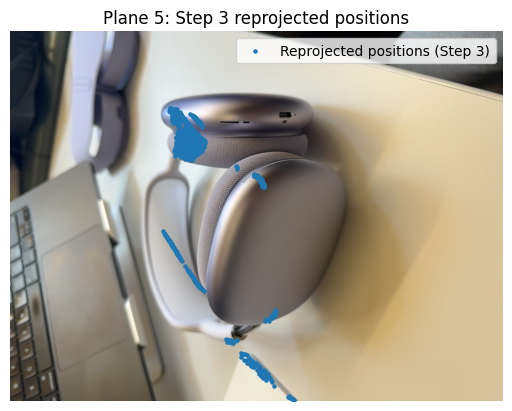

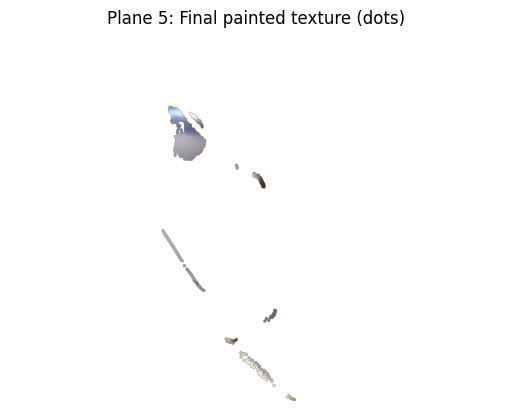

Done. Inspect the figures to verify each stage.


In [45]:
plane_index = 5  # <-- the i-th plane you want to inspect
result = debug_plane(processed_vignette, rgb_path, plane_index)

### More Tests ###

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 1) ---- Helper functions (kept small and explicit) ----

def project_points_to_2d(points_3d: np.ndarray, intrinsics: np.ndarray) -> np.ndarray:
    """
    STEP: Camera projection with intrinsics K only (no extrinsics):
        [u, v, 1]^T ~ K [X, Y, Z]^T
        => u = (K00*X + K01*Y + K02*Z) / Z
           v = (K10*X + K11*Y + K12*Z) / Z
    Args:
        points_3d: (N,3) array in camera/original coords
        intrinsics: (3,3) K matrix
    Returns:
        (N,2) pixel coordinates
    """
    P = intrinsics @ points_3d.T            # (3,N)
    z = P[2, :] + 1e-9                      # depth; epsilon to avoid div-by-zero
    u = P[0, :] / z
    v = P[1, :] / z
    return np.vstack((u, v)).T              # (N,2)



def project_point_to_plane(p: np.ndarray, p0: np.ndarray, n: np.ndarray) -> np.ndarray:
    """
    STEP: Orthogonal projection of a point p onto a plane (p0, n):
        q = p - ((p - p0)·n) * n
    """
    return p - np.dot(p - p0, n) * n

def project_axis_onto_plane(axis: np.ndarray, n: np.ndarray) -> np.ndarray:
    """
    STEP: Force a direction vector to lie in the plane by removing the component along n.
        axis_in_plane = axis - (axis·n) n
        then renormalize. If degenerate, pick a fallback.
    """
    a = axis / (np.linalg.norm(axis) + 1e-12)
    in_plane = a - np.dot(a, n) * n
    l = np.linalg.norm(in_plane)
    if l < 1e-9:
        # Fallback: pick any vector not parallel to n
        t = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(t, n)) > 0.9:
            t = np.array([0.0, 1.0, 0.0])
        in_plane = t - np.dot(t, n) * n
        in_plane /= (np.linalg.norm(in_plane) + 1e-12)
    else:
        in_plane /= l
    return in_plane

def gram_schmidt_uv(u_axis: np.ndarray, v_axis: np.ndarray, n: np.ndarray):
    """
    STEP: Make (u,v) orthonormal in the plane, right-handed with n:
        v <- v - (v·u) u ; normalize; if cross(u,v)·n < 0 then flip v.
    """
    u = u_axis / (np.linalg.norm(u_axis) + 1e-12)
    v = v_axis - np.dot(v_axis, u) * u
    v /= (np.linalg.norm(v) + 1e-12)
    if np.dot(np.cross(u, v), n) < 0:
        v = -v
    return u, v

def clamp_point_to_obb_on_plane(p_on_plane: np.ndarray,
                                center_on_plane: np.ndarray,
                                u_axis: np.ndarray, v_axis: np.ndarray,
                                u_half: float, v_half: float) -> np.ndarray:
    """
    STEP: Clamp an on-plane point to the in-plane rectangle defined by:
        center_on_plane ± u_half * u_axis ± v_half * v_axis
    Implementation:
        express in (u,v) coords relative to center; clamp each; map back.
    """
    rel = p_on_plane - center_on_plane
    u = float(np.dot(rel, u_axis))
    v = float(np.dot(rel, v_axis))
    u = np.clip(u, -u_half, u_half)
    v = np.clip(v, -v_half, v_half)
    return center_on_plane + u * u_axis + v * v_axis

def sample_disk_color_rgba(img: Image.Image, uv: np.ndarray, radius: int) -> tuple:
    """
    STEP: Average the RGBA color within a circular disk centered at pixel uv.
    Notes:
        - Uses a masked average inside the bounding crop for efficiency.
        - Returns (R,G,B,255) if any samples exist, otherwise (0,0,0,0).
    """
    w, h = img.size
    cx, cy = float(uv[0]), float(uv[1])
    x_min = max(int(np.floor(cx - radius)), 0)
    x_max = min(int(np.ceil (cx + radius)), w - 1)
    y_min = max(int(np.floor(cy - radius)), 0)
    y_max = min(int(np.ceil (cy + radius)), h - 1)
    if x_min > x_max or y_min > y_max:
        return (0, 0, 0, 0)

    crop = img.crop((x_min, y_min, x_max + 1, y_max + 1)).convert("RGBA")
    mask = Image.new("L", crop.size, 0)
    draw = ImageDraw.Draw(mask)
    ccx, ccy = cx - x_min, cy - y_min
    draw.ellipse((ccx - radius, ccy - radius, ccx + radius, ccy + radius), fill=255)

    crop_np = np.asarray(crop, dtype=np.float32)
    mask_np = np.asarray(mask, dtype=np.uint8)
    sel = mask_np > 0
    if not np.any(sel):
        return (0, 0, 0, 0)

    vals = crop_np[sel].reshape(-1, 4)
    mean = vals.mean(axis=0)
    r, g, b, a = [int(np.clip(v, 0, 255)) for v in mean]
    return (r, g, b, 255)  # Opaque paint (adjust if you want soft alpha)

In [23]:
import open3d as o3d
import numpy as np
from PIL import Image
from pathlib import Path
from scipy.spatial import ConvexHull

def find_minimum_bounding_rectangle(points_2d):
    """
    Finds the minimum area bounding rectangle for a set of 2D points.
    
    This is a robust implementation based on the "rotating calipers" principle.
    It finds the convex hull of the points and then iterates through each edge
    of the hull, finding the bounding box aligned with that edge. It returns
    the box with the minimum area found.

    Args:
        points_2d: An (N, 2) NumPy array of 2D points.

    Returns:
        An (4, 2) NumPy array containing the 2D coordinates of the four corners
        of the minimum area bounding rectangle.
    """
    # Step 1: Compute the convex hull of the points
    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]
    
    min_area = float('inf')
    best_box = None

    # Step 2: Iterate through each edge of the convex hull
    for i in range(len(hull_points)):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % len(hull_points)]
        
        # Step 3: Define a coordinate system aligned with the current edge
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])
        
        # Create the rotation matrix to align the edge with the X-axis
        c, s = np.cos(-edge_angle), np.sin(-edge_angle)
        rotation = np.array([[c, -s], [s, c]])
        
        # Step 4: Rotate all hull points into this new coordinate system
        rotated_points = hull_points @ rotation.T
        
        # Step 5: Find the Axis-Aligned Bounding Box (AABB) in the rotated frame
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        
        area = (max_x - min_x) * (max_y - min_y)
        
        # Step 6: If this box is the best so far, store its parameters
        if area < min_area:
            min_area = area
            # The corners of the AABB in the rotated frame
            corners_in_rotated_frame = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y]
            ])
            # Rotate the corners back to the original coordinate system
            inverse_rotation = rotation.T
            best_box = corners_in_rotated_frame @ inverse_rotation.T

    return best_box

def plane_equation_to_point_normal(equation, fallback_point):
    """Derives a point and normal from a plane equation [a,b,c,d]."""
    normal = equation[:3]
    normal = normal / np.linalg.norm(normal)
    # Find a point on the plane. A simple one is to project the fallback_point.
    v = fallback_point - np.array([0, 0, 0]) # Assuming origin for simplicity
    dist = np.dot(v, normal) + equation[3]
    point_on_plane = fallback_point - dist * normal
    return point_on_plane, normal

# Load the vignette
processed_vignette_path = results_path / "processed_vignette.npz"
from pipeline.vignette_data import ProcessedVignette
vignette = ProcessedVignette.load(processed_vignette_path)

# Target plane
plane_id = 5

# Get planes
planes = vignette.get_abstractions('planes')
plane = planes[plane_id]

# Get data
capture_meta = vignette.metadata.get('capture_metadata', {})
intrinsics = np.array(capture_meta.get('camera_intrinsics', {}).get('columns', np.identity(3))).T
center_offset = np.array(capture_meta.get('center_offset', [0, 0, 0]))

# Load image
source_image = Image.open(rgb_path).convert("RGBA")
im_w, im_h = source_image.size

# Get points
target_plane_info = next((p for p in planes if p.get('plane_id') == plane_id), None)
inlier_points_3d = processed_vignette.points[target_plane_info['point_indices']] + center_offset
inlier_points_centered = processed_vignette.points[target_plane_info['point_indices']]

# equation
eq = np.array(plane['equation'], dtype=np.float64)

assets_path = VIGNETTE_PATH / "assets" / "test"
assets_path.mkdir(parents=True, exist_ok=True)

# Get point & normal of plane
obb_center_world = np.array(plane['obb_center']) + center_offset
point_on_plane, normal = plane_equation_to_point_normal(eq, fallback_point=obb_center_world)

# Get the corners of the plane
# 1. 2D coordinate system
axis_z = normal
arbitrary_vec = np.array([0, 0, 1])
if np.allclose(np.abs(np.dot(axis_z, arbitrary_vec)), 1.0):
    arbitrary_vec = np.array([0, 1, 0])
        
axis_x = np.cross(axis_z, arbitrary_vec)
axis_x /= np.linalg.norm(axis_x)
axis_y = np.cross(axis_z, axis_x)

# 2. transform 3D points to 2D
vectors_from_origin = inlier_points_3d - point_on_plane
points_2d = np.vstack([
    np.dot(vectors_from_origin, axis_x),
    np.dot(vectors_from_origin, axis_y)
]).T

# 3. find 2D obb
corners_2d = find_minimum_bounding_rectangle(points_2d)

# 4. get the corners in 3D
corners_3d_centered = point_on_plane + corners_2d[:, 0, np.newaxis] * axis_x + corners_2d[:, 1, np.newaxis] * axis_y



Set/updated per-point attribute: 'confidence'.
Set/updated per-point attribute: 'plane_id'.
Set/updated per-point attribute: 'cylinder_id'.
Set/updated per-point attribute: 'sphere_id'.
Set/updated per-point attribute: 'cuboid_id'.
Set/updated per-point attribute: 'component_id'.
Set/updated per-point attribute: 'best_fit_id'.
Saved processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [ ]:
# Visualize

inlier_pcd = o3d.geometry.PointCloud()
inlier_pcd.points = o3d.utility.Vector3dVector(inlier_points_centered + center_offset)
inlier_pcd.paint_uniform_color([0.8, 0.8, 0.8])
        
corners_3d_world = corners_3d_centered + center_offset
point_on_plane_world = point_on_plane + center_offset
        
lines = [[0, 1], [1, 2], [2, 3], [3, 0]]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(corners_3d_world),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.paint_uniform_color([1, 0, 0])
        
origin_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.02).translate(point_on_plane_world)
origin_sphere.paint_uniform_color([0, 1, 0])
normal_line = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector([point_on_plane_world, point_on_plane_world + normal * 0.2]),
    lines=o3d.utility.Vector2iVector([[0, 1]]),
)
normal_line.paint_uniform_color([0, 0, 1])
        
o3d.visualization.draw([inlier_pcd, line_set, origin_sphere, normal_line])

### Tests ###

In [7]:
import open3d as o3d
import numpy as np
from PIL import Image
from pathlib import Path
from scipy.spatial import ConvexHull

def find_minimum_bounding_rectangle(points_2d):
    """
    Finds the minimum area bounding rectangle for a set of 2D points.
    
    This is a robust implementation based on the "rotating calipers" principle.
    It finds the convex hull of the points and then iterates through each edge
    of the hull, finding the bounding box aligned with that edge. It returns
    the box with the minimum area found.

    Args:
        points_2d: An (N, 2) NumPy array of 2D points.

    Returns:
        An (4, 2) NumPy array containing the 2D coordinates of the four corners
        of the minimum area bounding rectangle.
    """
    # Step 1: Compute the convex hull of the points
    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]
    
    min_area = float('inf')
    best_box = None

    # Step 2: Iterate through each edge of the convex hull
    for i in range(len(hull_points)):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % len(hull_points)]
        
        # Step 3: Define a coordinate system aligned with the current edge
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])
        
        # Create the rotation matrix to align the edge with the X-axis
        c, s = np.cos(-edge_angle), np.sin(-edge_angle)
        rotation = np.array([[c, -s], [s, c]])
        
        # Step 4: Rotate all hull points into this new coordinate system
        rotated_points = hull_points @ rotation.T
        
        # Step 5: Find the Axis-Aligned Bounding Box (AABB) in the rotated frame
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        
        area = (max_x - min_x) * (max_y - min_y)
        
        # Step 6: If this box is the best so far, store its parameters
        if area < min_area:
            min_area = area
            # The corners of the AABB in the rotated frame
            corners_in_rotated_frame = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y]
            ])
            # Rotate the corners back to the original coordinate system
            inverse_rotation = rotation.T
            best_box = corners_in_rotated_frame @ inverse_rotation.T

    return best_box

def plane_equation_to_point_normal(equation, fallback_point):
    """Derives a point and normal from a plane equation [a,b,c,d]."""
    normal = equation[:3]
    normal = normal / np.linalg.norm(normal)
    # Find a point on the plane. A simple one is to project the fallback_point.
    v = fallback_point - np.array([0, 0, 0]) # Assuming origin for simplicity
    dist = np.dot(v, normal) + equation[3]
    point_on_plane = fallback_point - dist * normal
    return point_on_plane, normal

# Load the vignette
# processed_vignette_path = results_path / "processed_vignette.npz"
# from pipeline.vignette_data import ProcessedVignette
# vignette = ProcessedVignette.load(processed_vignette_path)

# Target plane
plane_id = 5

# Get planes
planes = vignette.get_abstractions('planes')
target_plane_info = next((p for p in planes if p.get('plane_id') == plane_id), None)

if target_plane_info is None:
    print(f"Error: Plane with ID {plane_id} not found.")
else:
    # Get data
    capture_meta = vignette.metadata.get('capture_metadata', {})
    center_offset = np.array(capture_meta.get('center_offset', [0, 0, 0]))
    
    # Get points
    inlier_points_centered = vignette.points[target_plane_info['point_indices']]
    
    # equation
    eq = np.array(target_plane_info['equation'], dtype=np.float64)

    # --- FIX 1: All initial calculations must be in CENTERED space ---
    # The plane equation `eq` was calculated from centered points, so all
    # related geometric operations must also use centered points.
    
    # Get a fallback point that is also in centered space.
    obb_center_centered = np.array(target_plane_info['obb_center'])
    # The normal is a direction, so it's fine. point_on_plane is now correctly in centered space.
    point_on_plane_centered, normal = plane_equation_to_point_normal(eq, fallback_point=obb_center_centered)
    
    # Get the corners of the plane
    # 1. 2D coordinate system
    axis_z = normal
    arbitrary_vec = np.array([0, 0, 1])
    if np.allclose(np.abs(np.dot(axis_z, arbitrary_vec)), 1.0):
        arbitrary_vec = np.array([0, 1, 0])
            
    axis_x = np.cross(axis_z, arbitrary_vec)
    axis_x /= np.linalg.norm(axis_x)
    axis_y = np.cross(axis_z, axis_x)
    
    # 2. transform 3D points (CENTERED) to 2D
    vectors_from_origin = inlier_points_centered - point_on_plane_centered
    points_2d = np.vstack([
        np.dot(vectors_from_origin, axis_x),
        np.dot(vectors_from_origin, axis_y)
    ]).T
    
    # 3. find 2D bounding box
    if len(points_2d) < 3:
        print("Not enough points to compute a bounding box.")
    else:
        corners_2d = find_minimum_bounding_rectangle(points_2d)
        
        # 4. get the corners back in 3D (still in CENTERED space)
        corners_3d_centered = point_on_plane_centered + corners_2d[:, 0, np.newaxis] * axis_x + corners_2d[:, 1, np.newaxis] * axis_y
        
        # Visualize
        
        # The point cloud to be visualized must be in WORLD space
        inlier_pcd = o3d.geometry.PointCloud()
        inlier_pcd.points = o3d.utility.Vector3dVector(inlier_points_centered + center_offset)
        inlier_pcd.paint_uniform_color([0.8, 0.8, 0.8])
        
        # --- FIX 2: Translate ALL calculated geometries to WORLD space before drawing ---
        # The calculated corners, origin, and normal line must be shifted by the
        # center_offset to align with the world-space point cloud.
        corners_3d_world = corners_3d_centered + center_offset
        point_on_plane_world = point_on_plane_centered + center_offset
        
        lines = [[0, 1], [1, 2], [2, 3], [3, 0]]
        line_set = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(corners_3d_world),
            lines=o3d.utility.Vector2iVector(lines),
        )
        line_set.paint_uniform_color([1, 0, 0])
        
        origin_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.002).translate(point_on_plane_world)
        origin_sphere.paint_uniform_color([0, 1, 0])
        normal_line = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector([point_on_plane_world, point_on_plane_world + normal * 0.2]),
            lines=o3d.utility.Vector2iVector([[0, 1]]),
        )
        normal_line.paint_uniform_color([0, 0, 1])
        
        o3d.visualization.draw([inlier_pcd, line_set, origin_sphere, normal_line])

NameError: name 'vignette' is not defined

In [51]:
import open3d as o3d
import numpy as np
from PIL import Image, ImageOps, ImageDraw
from pathlib import Path
from scipy.spatial import ConvexHull
from typing import Dict, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- Helper Functions ---

def project_points_to_2d(points_3d, intrinsics):
    """Projects 3D points (in original camera space) to 2D image coordinates."""
    projected = intrinsics @ points_3d.T
    d = projected[2, :] + 1e-6
    u = projected[0, :] / d
    v = projected[1, :] / d
    return np.vstack((u, v)).T

def find_minimum_bounding_rectangle(points_2d):
    """Finds the minimum area bounding rectangle for a set of 2D points."""
    if len(points_2d) < 3: return None
    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]
    min_area = float('inf')
    best_box = None
    for i in range(len(hull_points)):
        p1, p2 = hull_points[i], hull_points[(i + 1) % len(hull_points)]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])
        c, s = np.cos(-edge_angle), np.sin(-edge_angle)
        rotation = np.array([[c, -s], [s, c]])
        rotated_points = hull_points @ rotation.T
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        area = (max_x - min_x) * (max_y - min_y)
        if area < min_area:
            min_area = area
            corners_in_rotated_frame = np.array([
                [min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]
            ])
            best_box = corners_in_rotated_frame @ rotation
    return best_box

def plane_equation_to_point_normal(equation, fallback_point):
    """Derives a point and normal from a plane equation [a,b,c,d]."""
    normal = equation[:3]
    normal_norm = np.linalg.norm(normal)
    if normal_norm == 0: return fallback_point, np.array([0,0,1])
    normal = normal / normal_norm
    v = fallback_point - np.array([0, 0, 0])
    dist = np.dot(v, normal) + equation[3]
    point_on_plane = fallback_point - dist * normal
    return point_on_plane, normal


# --- NEW Modular Functions ---

def load_plane_data(vignette, plane_id: int) -> Optional[Dict[str, Any]]:
    """Loads all necessary data for a specific plane from the vignette."""
    print(f"\n[Task 1] Loading data for Plane ID: {plane_id}...")
    planes = vignette.get_abstractions('planes')
    target_plane_info = next((p for p in planes if p.get('plane_id') == plane_id), None)

    if target_plane_info is None:
        print(f"   - ERROR: Plane with ID {plane_id} not found.")
        return None

    capture_meta = vignette.metadata.get('capture_metadata', {})
    center_offset = np.array(capture_meta.get('center_offset', [0, 0, 0]))
    intrinsics = np.array(capture_meta.get('camera_intrinsics', {}).get('columns', np.identity(3))).T
    
    return {
        "plane_info": target_plane_info,
        "inlier_points_centered": vignette.points[target_plane_info['point_indices']],
        "center_offset": center_offset,
        "intrinsics": intrinsics
    }

def get_plane_bounding_corners(inlier_points_centered, plane_equation) -> Optional[np.ndarray]:
    """Calculates the 4 corners of the plane's tightest bounding rectangle."""
    print("\n[Task 2] Calculating the 4 corners of the plane's bounding rectangle...")
    
    obb_center_centered = np.array(plane_equation.get('obb_center'))
    point_on_plane, normal = plane_equation_to_point_normal(plane_equation['equation'], fallback_point=obb_center_centered)
    
    axis_z = normal
    arbitrary_vec = np.array([0,0,1])
    if np.allclose(np.abs(np.dot(axis_z, arbitrary_vec)), 1.0): arbitrary_vec = np.array([0,1,0])
    axis_x = np.cross(axis_z, arbitrary_vec); axis_x /= np.linalg.norm(axis_x)
    axis_y = np.cross(axis_z, axis_x)
    
    vectors_from_origin = inlier_points_centered - point_on_plane
    points_2d = np.vstack([np.dot(vectors_from_origin, axis_x), np.dot(vectors_from_origin, axis_y)]).T
    
    corners_2d = find_minimum_bounding_rectangle(points_2d)
    if corners_2d is None:
        print("   - ERROR: Could not compute 2D bounding box.")
        return None
        
    corners_3d_centered = point_on_plane + corners_2d[:, 0, np.newaxis] * axis_x + corners_2d[:, 1, np.newaxis] * axis_y
    print("   - Successfully calculated 4 corners in 3D (centered space).")
    return corners_3d_centered

def get_pixel_coords(points_3d_world, intrinsics, description: str) -> np.ndarray:
    """Projects 3D world points to 2D pixel coordinates."""
    print(f"\n[Task] Projecting {description} to 2D pixel coordinates for debug plot...")
    points_2d = project_points_to_2d(points_3d_world, intrinsics)
    print(f"   - Calculated 2D pixel coordinates for {len(points_2d)} points.")
    return points_2d

def get_corner_uvs(corners_3d_centered, center_offset, intrinsics, image_size) -> np.ndarray:
    """Projects the 3D corners to the camera plane to get their UV coordinates."""
    print("\n[Task] Calculating UV coordinates for the 4 corners...")
    corners_3d_world = corners_3d_centered + center_offset
    corners_2d = project_points_to_2d(corners_3d_world, intrinsics)
    uvs = corners_2d / np.array(image_size)
    print("   - Successfully calculated 4 UV coordinates:")
    print(np.round(uvs, 3))
    return uvs

def project_inliers_onto_plane(inlier_points_centered, plane_equation) -> np.ndarray:
    """Projects the noisy inlier points onto the ideal mathematical plane."""
    print("\n[Task] Projecting inlier points onto the ideal plane...")
    eq = np.array(plane_equation['equation'])
    normal, d = eq[:3], eq[3]
    distances = inlier_points_centered @ normal + d
    projected_points_centered = inlier_points_centered - distances[:, np.newaxis] * normal
    print(f"   - Successfully projected {len(projected_points_centered)} points.")
    return projected_points_centered

def create_texture_from_corner_distortion(rgb_image_path, corners_3d_world, corners_2d_pixels, output_path):
    """Creates a perspective-corrected texture based on corner distortion."""
    print("\n[Task] Creating perspective-corrected texture from corner distortion...")

    try:
        source_image = Image.open(rgb_image_path)
        w, h = source_image.size
        print(f"   - Source image size: {w}x{h}")
    except Exception as e:
        print(f"   - ERROR: Could not load image. Error: {e}")
        return None

    edge_3d_1 = np.linalg.norm(corners_3d_world[1] - corners_3d_world[0])
    edge_3d_2 = np.linalg.norm(corners_3d_world[3] - corners_3d_world[0])
    edge_2d_1_vec = corners_2d_pixels[1] - corners_2d_pixels[0]
    edge_2d_2_vec = corners_2d_pixels[3] - corners_2d_pixels[0]
    edge_2d_1 = np.linalg.norm(edge_2d_1_vec)
    edge_2d_2 = np.linalg.norm(edge_2d_2_vec)
    
    if abs(edge_2d_1_vec[0]) > abs(edge_2d_1_vec[1]):
        h_edge_3d, v_edge_3d = edge_3d_1, edge_3d_2
        h_edge_2d, v_edge_2d = edge_2d_1, edge_2d_2
    else:
        h_edge_3d, v_edge_3d = edge_3d_2, edge_3d_1
        h_edge_2d, v_edge_2d = edge_2d_2, edge_2d_1

    print(f"   - Horizontal Edge: 3D length={h_edge_3d:.3f}m, 2D length={h_edge_2d:.2f}px")
    print(f"   - Vertical Edge:   3D length={v_edge_3d:.3f}m, 2D length={v_edge_2d:.2f}px")

    if h_edge_3d == 0 or v_edge_3d == 0:
        print("   - ERROR: 3D edge length is zero. Cannot calculate density.")
        return None
    density_h = h_edge_2d / h_edge_3d
    density_v = v_edge_2d / v_edge_3d
    print(f"   - Horizontal Density: {density_h:.2f} px/m")
    print(f"   - Vertical Density:   {density_v:.2f} px/m")

    if density_h == 0 or density_v == 0:
        print("   - ERROR: Pixel density is zero. Cannot calculate scale factor.")
        return None
        
    target_density = max(density_h, density_v)
    scale_w = target_density / density_h
    scale_h = target_density / density_v
    print(f"   - Required scale factor for width: {scale_w:.2f}")
    print(f"   - Required scale factor for height: {scale_h:.2f}")

    new_w = int(w * scale_w)
    new_h = int(h * scale_h)

    if new_w == 0 or new_h == 0:
        print(f"   - ERROR: Calculated new image dimensions are invalid ({new_w}x{new_h}).")
        return None

    print(f"   - Final upscaled image size: {new_w}x{new_h}")
    
    upscaled_image = source_image.resize((new_w, new_h), Image.Resampling.LANCZOS)
    upscaled_image.save(output_path)
    print(f"   - Saved upscaled texture to: {output_path}")
    return (new_w, new_h)

def create_mask_on_texture(texture_path, scaled_points_2d, point_radius, output_mask_path):
    """Creates and saves a mask by drawing circles on a blank canvas."""
    print("\n[Task] Creating mask for the upscaled texture...")
    try:
        texture = Image.open(texture_path)
        mask = Image.new('L', texture.size, 0) # 'L' is for 8-bit grayscale
        draw = ImageDraw.Draw(mask)
        
        for p in scaled_points_2d:
            bbox = (p[0] - point_radius, p[1] - point_radius, p[0] + point_radius, p[1] + point_radius)
            draw.ellipse(bbox, fill=255)
            
        mask.save(output_mask_path)
        print(f"   - Saved mask to: {output_mask_path}")
    except Exception as e:
        print(f"   - ERROR: Could not create mask. Error: {e}")

def visualize_points_on_image(rgb_image_path, points1, title1, points2, title2):
    """Loads an image and plots two sets of 2D points on top of it side-by-side."""
    print(f"\n[Visualization] Displaying two debug plots side-by-side...")
    try:
        img = mpimg.imread(rgb_image_path)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10 * img.shape[0] / img.shape[1]))
        ax1.imshow(img); ax1.scatter(points1[:, 0], points1[:, 1], s=5, c='red', alpha=0.5); ax1.set_title(title1)
        ax2.imshow(img); ax2.scatter(points2[:, 0], points2[:, 1], s=5, c='cyan', alpha=0.5); ax2.set_title(title2)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"   - ERROR: Could not plot points on image. Matplotlib error: {e}")

def visualize_3d_projection(inlier_points_world, projected_points_world, corners_3d_world, plane_id: int):
    """Draws the original points, projected points, connecting lines, and bounding rectangle."""
    print("\n[Visualization] Displaying the 3D projection results...")
    original_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(inlier_points_world)); original_pcd.paint_uniform_color([0.8, 0.8, 0.8])
    projected_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(projected_points_world)); projected_pcd.paint_uniform_color([1.0, 0.7, 0.0])
    num_points = len(inlier_points_world); line_points = np.vstack([inlier_points_world, projected_points_world]); line_indices = [[i, i + num_points] for i in range(num_points)]
    connecting_lines = o3d.geometry.LineSet(points=o3d.utility.Vector3dVector(line_points), lines=o3d.utility.Vector2iVector(line_indices)); connecting_lines.paint_uniform_color([0.0, 0.8, 0.8])
    rect_lines = [[0, 1], [1, 2], [2, 3], [3, 0]]; bounding_rectangle = o3d.geometry.LineSet(points=o3d.utility.Vector3dVector(corners_3d_world), lines=o3d.utility.Vector2iVector(rect_lines)); bounding_rectangle.paint_uniform_color([1, 0, 0])
    o3d.visualization.draw([original_pcd, projected_pcd, connecting_lines, bounding_rectangle])


def analyze_and_visualize_plane(vignette, plane_id: int, rgb_image_path: str):
    """Main orchestrator function that runs the full analysis pipeline."""
    
    # Task 1: Load data
    data = load_plane_data(vignette, plane_id)
    if data is None: return

    # Task 2: Get corners
    corners_3d_centered = get_plane_bounding_corners(data['inlier_points_centered'], data['plane_info'])
    if corners_3d_centered is None: return
    
    # Task 3: Get pixel coordinates of corners and inliers
    corners_3d_world = corners_3d_centered + data['center_offset']
    corners_2d_pixels = project_points_to_2d(corners_3d_world, data['intrinsics'])
    inlier_points_world = data['inlier_points_centered'] + data['center_offset']
    inlier_pixel_coords = get_pixel_coords(inlier_points_world, data['intrinsics'], "original inlier points")
    
    # Task 4: Create the Perspective-Corrected Texture
    assets_path = Path(rgb_image_path).parent / "assets" / "test"
    assets_path.mkdir(parents=True, exist_ok=True)
    output_texture_path = assets_path / f"plane_{plane_id}_perspective_corrected.png"
    new_dims = create_texture_from_corner_distortion(
        rgb_image_path,
        corners_3d_world,
        corners_2d_pixels,
        str(output_texture_path)
    )
    
    # Task 5: Project inliers onto ideal plane
    projected_points_centered = project_inliers_onto_plane(data['inlier_points_centered'], data['plane_info'])
    projected_points_world = projected_points_centered + data['center_offset']
    projected_pixel_coords = get_pixel_coords(projected_points_world, data['intrinsics'], "flattened (projected) points")
    
    # Visualization 1: Side-by-side plot on ORIGINAL image
    visualize_points_on_image(rgb_image_path, inlier_pixel_coords, "Original Points on Source Image", projected_pixel_coords, "Ideal Plane Points on Source Image")
    
    # Visualization 2 & Task 6 (NEW): Create mask and plot on UPSCALED image
    if new_dims:
        try:
            source_image = Image.open(rgb_image_path)
            w, h = source_image.size
            new_w, new_h = new_dims
            
            scale_w, scale_h = new_w / w, new_h / h
            
            scaled_inlier_coords = inlier_pixel_coords * np.array([scale_w, scale_h])
            scaled_projected_coords = projected_pixel_coords * np.array([scale_w, scale_h])

            visualize_points_on_image(
                str(output_texture_path),
                scaled_inlier_coords, "Original Points on Upscaled Texture",
                scaled_projected_coords, "Ideal Plane Points on Upscaled Texture"
            )

            # --- NEW TASK: Create the mask for the upscaled texture ---
            output_mask_path = assets_path / f"plane_{plane_id}_mask.png"
            create_mask_on_texture(
                str(output_texture_path),
                scaled_projected_coords,
                point_radius=10, # You can adjust this radius
                output_mask_path=str(output_mask_path)
            )

        except Exception as e:
            print(f"ERROR during upscaled visualization or mask creation: {e}")
            
    # Visualization 3: Final 3D visualization
    visualize_3d_projection(inlier_points_world, projected_points_world, corners_3d_world, plane_id)


# --- Example Usage (in your Jupyter notebook) ---
# from pipeline.vignette_data import ProcessedVignette
# from pathlib import Path

# VIGNETTE_DIR = Path("path/to/your/vignette_folder")
# processed_vignette = ProcessedVignette.load(VIGNETTE_DIR / "results" / "processed_vignette.npz")
# rgb_path = VIGNETTE_DIR / "rgb.png"

# analyze_and_visualize_plane(processed_vignette, plane_id=5, rgb_image_path=str(rgb_path))



In [49]:
import open3d as o3d
import numpy as np
from PIL import Image, ImageOps, ImageDraw
from pathlib import Path
from scipy.spatial import ConvexHull
from typing import Dict, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import SciPy for interpolation and image warping
from scipy.interpolate import griddata
from scipy.ndimage import map_coordinates

# --- Helper Functions ---

def project_points_to_2d(points_3d, intrinsics):
    """Projects 3D points (in original camera space) to 2D image coordinates."""
    projected = intrinsics @ points_3d.T
    d = projected[2, :] + 1e-6
    u = projected[0, :] / d
    v = projected[1, :] / d
    return np.vstack((u, v)).T

def find_minimum_bounding_rectangle(points_2d):
    """Finds the minimum area bounding rectangle for a set of 2D points."""
    if len(points_2d) < 3: return None
    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]
    min_area = float('inf')
    best_box = None
    for i in range(len(hull_points)):
        p1, p2 = hull_points[i], hull_points[(i + 1) % len(hull_points)]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])
        c, s = np.cos(-edge_angle), np.sin(-edge_angle)
        rotation = np.array([[c, -s], [s, c]])
        rotated_points = hull_points @ rotation.T
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        area = (max_x - min_x) * (max_y - min_y)
        if area < min_area:
            min_area = area
            corners_in_rotated_frame = np.array([
                [min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]
            ])
            best_box = corners_in_rotated_frame @ rotation
    return best_box

def plane_equation_to_point_normal(equation, fallback_point):
    """Derives a point and normal from a plane equation [a,b,c,d]."""
    normal = equation[:3]
    normal_norm = np.linalg.norm(normal)
    if normal_norm == 0: return fallback_point, np.array([0,0,1])
    normal = normal / normal_norm
    v = fallback_point - np.array([0, 0, 0])
    dist = np.dot(v, normal) + equation[3]
    point_on_plane = fallback_point - dist * normal
    return point_on_plane, normal


# --- Modular Functions ---

def load_plane_data(vignette, plane_id: int) -> Optional[Dict[str, Any]]:
    """Loads all necessary data for a specific plane from the vignette."""
    print(f"\n[Task 1] Loading data for Plane ID: {plane_id}...")
    planes = vignette.get_abstractions('planes')
    target_plane_info = next((p for p in planes if p.get('plane_id') == plane_id), None)
    if target_plane_info is None:
        print(f"   - ERROR: Plane with ID {plane_id} not found.")
        return None
    capture_meta = vignette.metadata.get('capture_metadata', {})
    center_offset = np.array(capture_meta.get('center_offset', [0, 0, 0]))
    intrinsics = np.array(capture_meta.get('camera_intrinsics', {}).get('columns', np.identity(3))).T
    return {
        "plane_info": target_plane_info,
        "inlier_points_centered": vignette.points[target_plane_info['point_indices']],
        "center_offset": center_offset,
        "intrinsics": intrinsics
    }

def get_plane_bounding_corners(inlier_points_centered, plane_equation) -> Optional[np.ndarray]:
    """Calculates the 4 corners of the plane's tightest bounding rectangle."""
    print("\n[Task 2] Calculating the 4 corners of the plane's bounding rectangle...")
    obb_center_centered = np.array(plane_equation.get('obb_center'))
    point_on_plane, normal = plane_equation_to_point_normal(plane_equation['equation'], fallback_point=obb_center_centered)
    axis_z = normal
    arbitrary_vec = np.array([0,0,1])
    if np.allclose(np.abs(np.dot(axis_z, arbitrary_vec)), 1.0): arbitrary_vec = np.array([0,1,0])
    axis_x = np.cross(axis_z, arbitrary_vec); axis_x /= np.linalg.norm(axis_x)
    axis_y = np.cross(axis_z, axis_x)
    vectors_from_origin = inlier_points_centered - point_on_plane
    points_2d = np.vstack([np.dot(vectors_from_origin, axis_x), np.dot(vectors_from_origin, axis_y)]).T
    corners_2d = find_minimum_bounding_rectangle(points_2d)
    if corners_2d is None:
        print("   - ERROR: Could not compute 2D bounding box.")
        return None
    corners_3d_centered = point_on_plane + corners_2d[:, 0, np.newaxis] * axis_x + corners_2d[:, 1, np.newaxis] * axis_y
    print("   - Successfully calculated 4 corners in 3D (centered space).")
    return corners_3d_centered

def get_pixel_coords(points_3d_world, intrinsics, description: str) -> np.ndarray:
    """Projects 3D world points to 2D pixel coordinates."""
    print(f"\n[Task] Projecting {description} to 2D pixel coordinates for debug plot...")
    points_2d = project_points_to_2d(points_3d_world, intrinsics)
    print(f"   - Calculated 2D pixel coordinates for {len(points_2d)} points.")
    return points_2d

def project_inliers_onto_plane(inlier_points_centered, plane_equation) -> np.ndarray:
    """Projects the noisy inlier points onto the ideal mathematical plane."""
    print("\n[Task] Projecting inlier points onto the ideal plane...")
    eq = np.array(plane_equation['equation'])
    normal, d = eq[:3], eq[3]
    distances = inlier_points_centered @ normal + d
    projected_points_centered = inlier_points_centered - distances[:, np.newaxis] * normal
    print(f"   - Successfully projected {len(projected_points_centered)} points.")
    return projected_points_centered

def create_texture_from_corner_distortion(rgb_image_path, corners_3d_world, corners_2d_pixels, output_path):
    """Creates a perspective-corrected texture based on corner distortion."""
    print("\n[Task] Creating perspective-corrected texture from corner distortion...")
    try:
        source_image = Image.open(rgb_image_path)
        w, h = source_image.size
    except Exception as e:
        print(f"   - ERROR: Could not load image. Error: {e}")
        return None
    edge_3d_1, edge_3d_2 = np.linalg.norm(corners_3d_world[1] - corners_3d_world[0]), np.linalg.norm(corners_3d_world[3] - corners_3d_world[0])
    edge_2d_1_vec, edge_2d_2_vec = corners_2d_pixels[1] - corners_2d_pixels[0], corners_2d_pixels[3] - corners_2d_pixels[0]
    edge_2d_1, edge_2d_2 = np.linalg.norm(edge_2d_1_vec), np.linalg.norm(edge_2d_2_vec)
    if abs(edge_2d_1_vec[0]) > abs(edge_2d_1_vec[1]):
        h_edge_3d, v_edge_3d, h_edge_2d, v_edge_2d = edge_3d_1, edge_3d_2, edge_2d_1, edge_2d_2
    else:
        h_edge_3d, v_edge_3d, h_edge_2d, v_edge_2d = edge_3d_2, edge_3d_1, edge_2d_2, edge_2d_1
    if h_edge_3d == 0 or v_edge_3d == 0: return None
    density_h, density_v = h_edge_2d / h_edge_3d, v_edge_2d / v_edge_3d
    if density_h == 0 or density_v == 0: return None
    target_density = max(density_h, density_v)
    scale_w, scale_h = target_density / density_h, target_density / density_v
    new_w, new_h = int(w * scale_w), int(h * scale_h)
    if new_w == 0 or new_h == 0: return None
    print(f"   - Final upscaled image size: {new_w}x{new_h}")
    upscaled_image = source_image.resize((new_w, new_h), Image.Resampling.LANCZOS)
    upscaled_image.save(output_path)
    print(f"   - Saved upscaled texture to: {output_path}")
    return (new_w, new_h)

def create_mask_on_texture(texture_path, scaled_points_2d, point_radius, output_mask_path):
    """Creates and saves a mask by drawing circles on a blank canvas."""
    print("\n[Task] Creating mask for the upscaled texture...")
    try:
        texture = Image.open(texture_path)
        mask = Image.new('L', texture.size, 0)
        draw = ImageDraw.Draw(mask)
        for p in scaled_points_2d:
            bbox = (p[0] - point_radius, p[1] - point_radius, p[0] + point_radius, p[1] + point_radius)
            draw.ellipse(bbox, fill=255)
        mask.save(output_mask_path)
        print(f"   - Saved mask to: {output_mask_path}")
    except Exception as e:
        print(f"   - ERROR: Could not create mask. Error: {e}")

def create_distorted_texture(source_image_path, source_points, dest_points, output_path):
    """Warps an image based on a sparse vector field of moving points."""
    print("\n[Task] Creating distorted texture using vector field warp...")
    try:
        source_image = np.array(Image.open(source_image_path))
        h, w, _ = source_image.shape
    except Exception as e:
        print(f"   - ERROR: Could not load source upscaled image. Error: {e}")
        return

    vectors = dest_points - source_points
    print(f"   - Calculated {len(vectors)} displacement vectors. Example vector: {vectors[0].round(2)}")
    
    grid_y, grid_x = np.mgrid[0:h, 0:w]
    print(f"   - Created destination grid of size (h, w): ({h}, {w})")

    displacement_field = griddata(dest_points, vectors, (grid_x, grid_y), method='cubic', fill_value=0)
    print(f"   - Interpolated sparse vector field to a dense one of shape: {displacement_field.shape}")

    map_y = grid_y - displacement_field[:,:,1]
    map_x = grid_x - displacement_field[:,:,0]
    
    warped_image_r = map_coordinates(source_image[:,:,0], [map_y, map_x], order=1, mode='constant', cval=0)
    warped_image_g = map_coordinates(source_image[:,:,1], [map_y, map_x], order=1, mode='constant', cval=0)
    warped_image_b = map_coordinates(source_image[:,:,2], [map_y, map_x], order=1, mode='constant', cval=0)
    
    distorted_image_np = np.stack([warped_image_r, warped_image_g, warped_image_b], axis=-1).astype(np.uint8)
    distorted_image = Image.fromarray(distorted_image_np)
    
    distorted_image.save(output_path)
    print(f"   - Saved distorted texture to: {output_path}")

def visualize_distortion(original_path, distorted_path, source_points, dest_points):
    """Loads and displays a 2x2 grid of distortion comparison images."""
    print("\n[Visualization] Displaying before and after distortion...")
    try:
        img_orig = mpimg.imread(original_path)
        img_dist = mpimg.imread(distorted_path)
        
        # Create a 2x2 grid of subplots for a more comprehensive view
        fig, axes = plt.subplots(2, 2, figsize=(20, 20 * img_orig.shape[0] / img_orig.shape[1]))
        
        # Top-Left: Original upscaled image
        axes[0, 0].imshow(img_orig)
        axes[0, 0].set_title("Before Distortion (Upscaled)")
        axes[0, 0].axis('off')

        # Top-Right: Distorted (warped) image
        axes[0, 1].imshow(img_dist)
        axes[0, 1].set_title("After Distortion (Warped)")
        axes[0, 1].axis('off')

        # Bottom-Left: Original with "before" points overlaid
        axes[1, 0].imshow(img_orig)
        axes[1, 0].scatter(source_points[:, 0], source_points[:, 1], s=2, c='red', alpha=0.5)
        axes[1, 0].set_title("Before Points Overlay")
        axes[1, 0].axis('off')

        # Bottom-Right: Distorted with "after" points overlaid
        axes[1, 1].imshow(img_dist)
        axes[1, 1].scatter(dest_points[:, 0], dest_points[:, 1], s=2, c='cyan', alpha=0.5)
        axes[1, 1].set_title("After Points Overlay")
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   - ERROR: Could not plot distortion comparison. Matplotlib error: {e}")

def visualize_points_on_image(rgb_image_path, points1, title1, points2, title2):
    """Loads an image and plots two sets of 2D points on top of it side-by-side."""
    print(f"\n[Visualization 1] Displaying two debug plots side-by-side...")
    try:
        img = mpimg.imread(rgb_image_path)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10 * img.shape[0] / img.shape[1]))
        ax1.imshow(img)
        ax1.scatter(points1[:, 0], points1[:, 1], s=5, c='red', alpha=0.5)
        ax1.set_title(title1)
        ax1.set_xlabel("U coordinate (pixels)")
        ax1.set_ylabel("V coordinate (pixels)")

        ax2.imshow(img)
        ax2.scatter(points2[:, 0], points2[:, 1], s=5, c='cyan', alpha=0.5)
        ax2.set_title(title2)
        ax2.set_xlabel("U coordinate (pixels)")
        ax2.set_ylabel("V coordinate (pixels)")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   - ERROR: Could not plot points on image. Matplotlib error: {e}")

def visualize_3d_projection(inlier_points_world, projected_points_world, corners_3d_world, plane_id: int):
    """Draws the original points, projected points, connecting lines, and bounding rectangle."""
    print("\n[Visualization 2] Displaying the 3D projection results...")
    
    original_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(inlier_points_world))
    original_pcd.paint_uniform_color([0.8, 0.8, 0.8])

    projected_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(projected_points_world))
    projected_pcd.paint_uniform_color([1.0, 0.7, 0.0])

    num_points = len(inlier_points_world)
    line_points = np.vstack([inlier_points_world, projected_points_world])
    line_indices = [[i, i + num_points] for i in range(num_points)]
    connecting_lines = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(line_points),
        lines=o3d.utility.Vector2iVector(line_indices)
    )
    connecting_lines.paint_uniform_color([0.0, 0.8, 0.8])
    
    rect_lines = [[0, 1], [1, 2], [2, 3], [3, 0]]
    bounding_rectangle = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(corners_3d_world),
        lines=o3d.utility.Vector2iVector(rect_lines),
    )
    bounding_rectangle.paint_uniform_color([1, 0, 0])
    
    geometries_to_draw = [original_pcd, projected_pcd, connecting_lines, bounding_rectangle]
    
    o3d.visualization.draw(geometries_to_draw, window_name=f"3D Projection for Plane {plane_id}")


def analyze_and_visualize_plane(vignette, plane_id: int, rgb_image_path: str):
    """Main orchestrator function that runs the full analysis pipeline."""
    
    data = load_plane_data(vignette, plane_id)
    if data is None: return

    corners_3d_centered = get_plane_bounding_corners(data['inlier_points_centered'], data['plane_info'])
    if corners_3d_centered is None: return
    
    corners_3d_world = corners_3d_centered + data['center_offset']
    corners_2d_pixels = project_points_to_2d(corners_3d_world, data['intrinsics'])
    
    assets_path = Path(rgb_image_path).parent / "assets" / "test"
    assets_path.mkdir(parents=True, exist_ok=True)
    output_texture_path = assets_path / f"plane_{plane_id}_perspective_corrected.png"
    new_dims = create_texture_from_corner_distortion(rgb_image_path, corners_3d_world, corners_2d_pixels, str(output_texture_path))
    
    projected_points_centered = project_inliers_onto_plane(data['inlier_points_centered'], data['plane_info'])
    
    if new_dims:
        try:
            source_image = Image.open(rgb_image_path)
            w, h = source_image.size
            new_w, new_h = new_dims
            scale_w, scale_h = new_w / w, new_h / h
            
            inlier_points_world = data['inlier_points_centered'] + data['center_offset']
            inlier_pixel_coords = project_points_to_2d(inlier_points_world, data['intrinsics'])
            scaled_inlier_coords = inlier_pixel_coords * np.array([scale_w, scale_h])
            
            projected_points_world = projected_points_centered + data['center_offset']
            projected_pixel_coords = project_points_to_2d(projected_points_world, data['intrinsics'])
            scaled_projected_coords = projected_pixel_coords * np.array([scale_w, scale_h])

            output_distorted_path = assets_path / f"plane_{plane_id}_distorted.png"
            create_distorted_texture(
                str(output_texture_path),
                scaled_inlier_coords,
                scaled_projected_coords,
                str(output_distorted_path)
            )

            visualize_distortion(
                str(output_texture_path),
                str(output_distorted_path),
                scaled_inlier_coords,
                scaled_projected_coords
            )

            output_mask_path = assets_path / f"plane_{plane_id}_mask.png"
            create_mask_on_texture(
                str(output_distorted_path),
                scaled_projected_coords,
                point_radius=10,
                output_mask_path=str(output_mask_path)
            )

        except Exception as e:
            print(f"ERROR during upscaled processing: {e}")
            
# --- Example Usage (in your Jupyter notebook) ---
# ...



In [ ]:
#visualize_points_on_image(rgb_image_path, inlier_pixel_coords, "Original Points", projected_pixel_coords, "Ideal Plane Points")

Set/updated per-point attribute: 'confidence'.
Set/updated per-point attribute: 'plane_id'.
Set/updated per-point attribute: 'cylinder_id'.
Set/updated per-point attribute: 'sphere_id'.
Set/updated per-point attribute: 'cuboid_id'.
Set/updated per-point attribute: 'component_id'.
Set/updated per-point attribute: 'best_fit_id'.
Loaded processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz

[Task 1] Loading data for Plane ID: 1...

[Task 2] Calculating the 4 corners of the plane's bounding rectangle...
   - Successfully calculated 4 corners in 3D (centered space).

[Task] Projecting original inlier points to 2D pixel coordinates for debug plot...
   - Calculated 2D pixel coordinates for 2793 points.

[Task] Creating perspective-corrected texture from corner distortion...
   - Source image size: 1920x1440
   - Horizontal Edge: 3D length=0.073m, 2D length=417.09px
   - Vertical Edge:   3D length=0.166m,

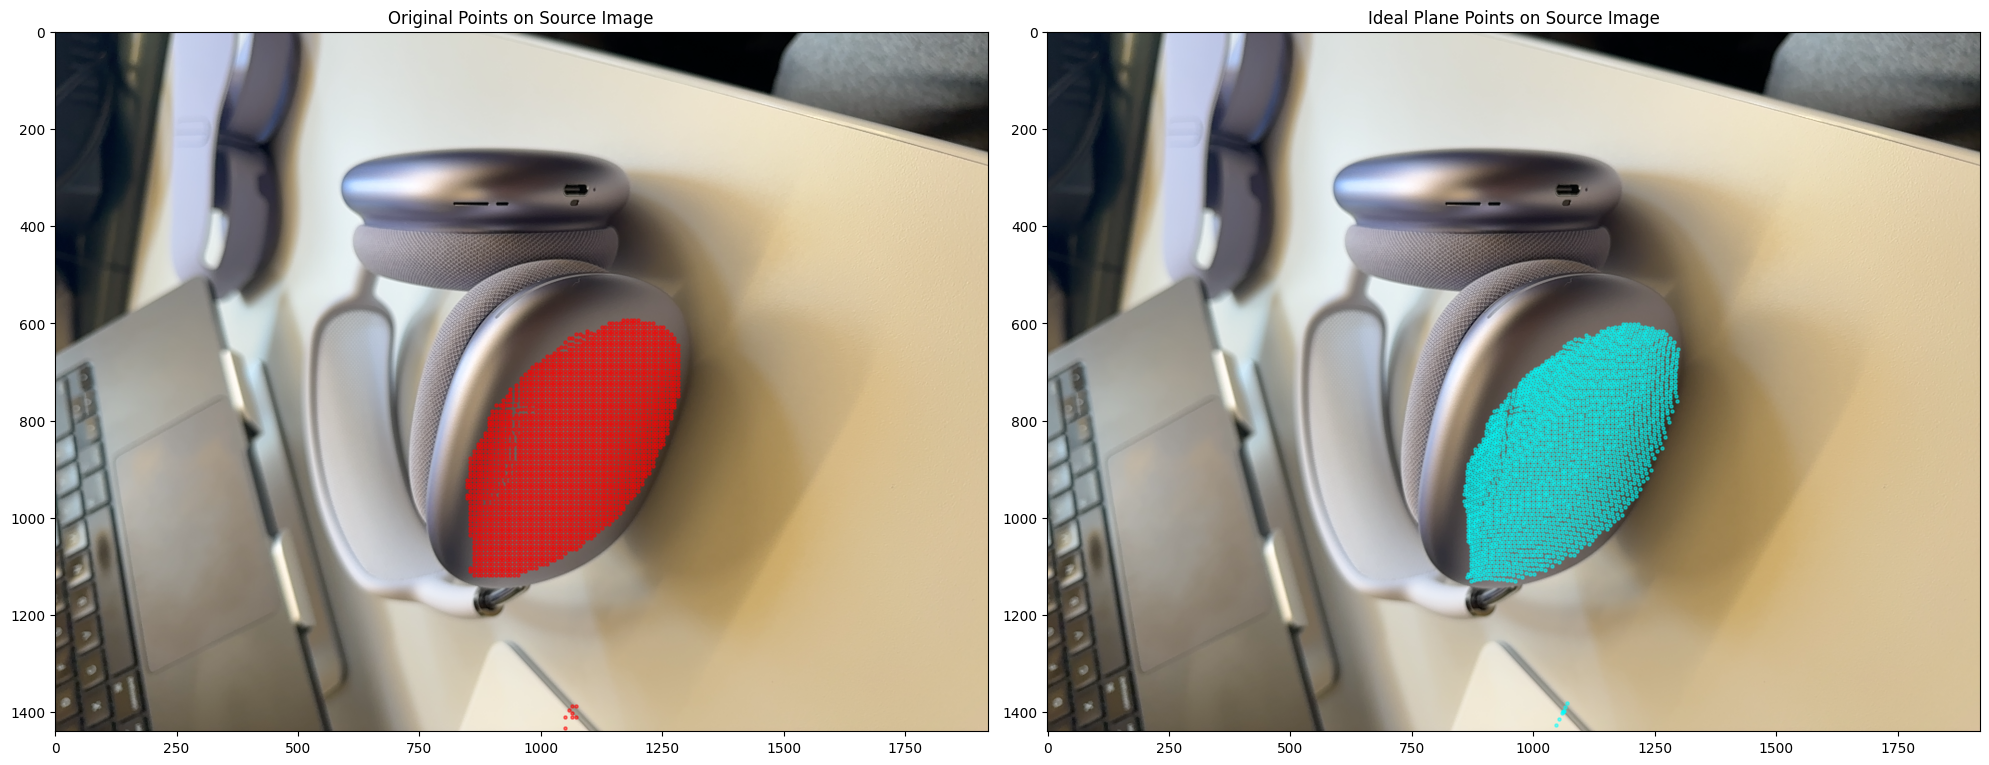


[Visualization] Displaying two debug plots side-by-side...


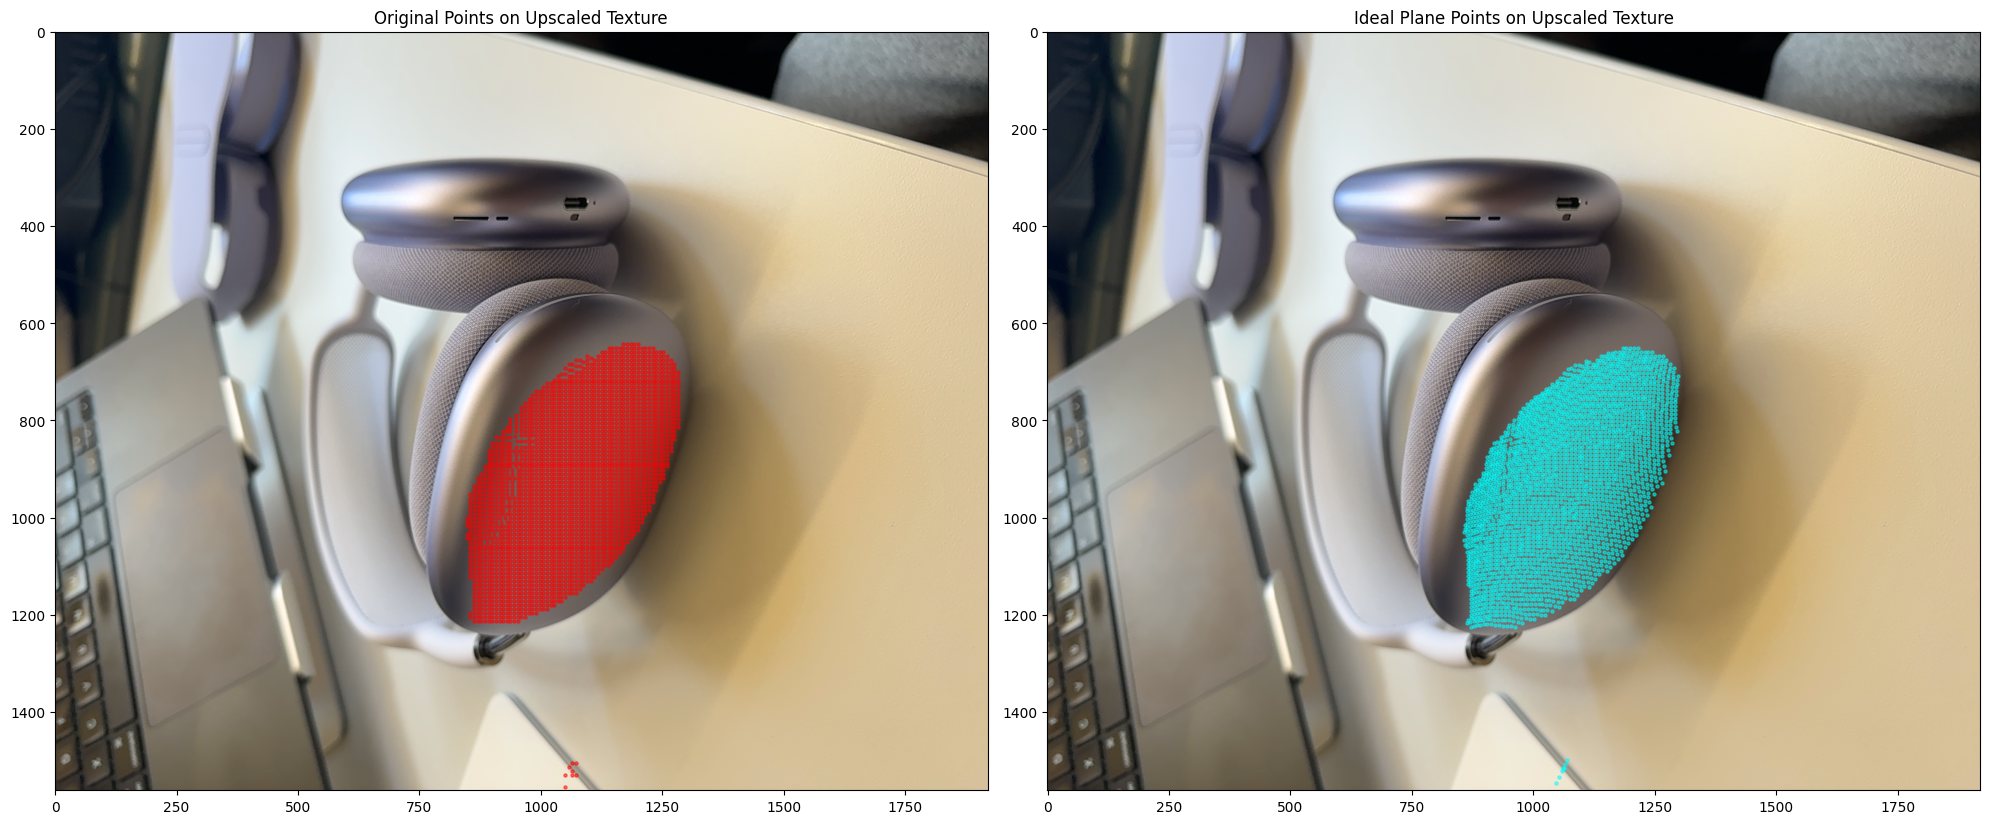


[Task] Creating mask for the upscaled texture...
   - Saved mask to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/assets/test/plane_1_mask.png

[Visualization] Displaying the 3D projection results...


: 

In [ ]:
processed_vignette_path = results_path / "processed_vignette.npz"
from pipeline.vignette_data import ProcessedVignette
processed_vignette = ProcessedVignette.load(processed_vignette_path)
analyze_and_visualize_plane(processed_vignette, plane_id=1, rgb_image_path=str(rgb_path))

In [48]:
# With Saving

import open3d as o3d
import numpy as np
from PIL import Image, ImageOps, ImageDraw
from pathlib import Path
from scipy.spatial import ConvexHull
from typing import Dict, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import SciPy for interpolation and image warping
from scipy.interpolate import griddata
from scipy.ndimage import map_coordinates

# --- Helper Functions ---

def project_points_to_2d(points_3d, intrinsics):
    """Projects 3D points (in original camera space) to 2D image coordinates."""
    projected = intrinsics @ points_3d.T
    d = projected[2, :] + 1e-6
    u = projected[0, :] / d
    v = projected[1, :] / d
    return np.vstack((u, v)).T

def find_minimum_bounding_rectangle(points_2d):
    """Finds the minimum area bounding rectangle for a set of 2D points."""
    if len(points_2d) < 3: return None
    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]
    min_area = float('inf')
    best_box = None
    for i in range(len(hull_points)):
        p1, p2 = hull_points[i], hull_points[(i + 1) % len(hull_points)]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])
        c, s = np.cos(-edge_angle), np.sin(-edge_angle)
        rotation = np.array([[c, -s], [s, c]])
        rotated_points = hull_points @ rotation.T
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        area = (max_x - min_x) * (max_y - min_y)
        if area < min_area:
            min_area = area
            corners_in_rotated_frame = np.array([
                [min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]
            ])
            best_box = corners_in_rotated_frame @ rotation
    return best_box

def plane_equation_to_point_normal(equation, fallback_point):
    """Derives a point and normal from a plane equation [a,b,c,d]."""
    normal = equation[:3]
    normal_norm = np.linalg.norm(normal)
    if normal_norm == 0: return fallback_point, np.array([0,0,1])
    normal = normal / normal_norm
    v = fallback_point - np.array([0, 0, 0])
    dist = np.dot(v, normal) + equation[3]
    point_on_plane = fallback_point - dist * normal
    return point_on_plane, normal


# --- Modular Functions ---

def load_plane_data(vignette, plane_id: int) -> Optional[Dict[str, Any]]:
    """Loads all necessary data for a specific plane from the vignette."""
    print(f"\n[Task 1] Loading data for Plane ID: {plane_id}...")
    planes = vignette.get_abstractions('planes')
    target_plane_info = next((p for p in planes if p.get('plane_id') == plane_id), None)
    if target_plane_info is None:
        print(f"   - ERROR: Plane with ID {plane_id} not found.")
        return None
    capture_meta = vignette.metadata.get('capture_metadata', {})
    center_offset = np.array(capture_meta.get('center_offset', [0, 0, 0]))
    intrinsics = np.array(capture_meta.get('camera_intrinsics', {}).get('columns', np.identity(3))).T
    return {
        "plane_info": target_plane_info,
        "inlier_points_centered": vignette.points[target_plane_info['point_indices']],
        "center_offset": center_offset,
        "intrinsics": intrinsics
    }

def get_plane_bounding_corners(inlier_points_centered, plane_equation) -> Optional[np.ndarray]:
    """Calculates the 4 corners of the plane's tightest bounding rectangle."""
    print("\n[Task 2] Calculating the 4 corners of the plane's bounding rectangle...")
    obb_center_centered = np.array(plane_equation.get('obb_center'))
    point_on_plane, normal = plane_equation_to_point_normal(plane_equation['equation'], fallback_point=obb_center_centered)
    axis_z = normal
    arbitrary_vec = np.array([0,0,1])
    if np.allclose(np.abs(np.dot(axis_z, arbitrary_vec)), 1.0): arbitrary_vec = np.array([0,1,0])
    axis_x = np.cross(axis_z, arbitrary_vec); axis_x /= np.linalg.norm(axis_x)
    axis_y = np.cross(axis_z, axis_x)
    vectors_from_origin = inlier_points_centered - point_on_plane
    points_2d = np.vstack([np.dot(vectors_from_origin, axis_x), np.dot(vectors_from_origin, axis_y)]).T
    corners_2d = find_minimum_bounding_rectangle(points_2d)
    if corners_2d is None:
        print("   - ERROR: Could not compute 2D bounding box.")
        return None
    corners_3d_centered = point_on_plane + corners_2d[:, 0, np.newaxis] * axis_x + corners_2d[:, 1, np.newaxis] * axis_y
    print("   - Successfully calculated 4 corners in 3D (centered space).")
    return corners_3d_centered

def get_pixel_coords(points_3d_world, intrinsics, description: str) -> np.ndarray:
    """Projects 3D world points to 2D pixel coordinates."""
    print(f"\n[Task] Projecting {description} to 2D pixel coordinates for debug plot...")
    points_2d = project_points_to_2d(points_3d_world, intrinsics)
    print(f"   - Calculated 2D pixel coordinates for {len(points_2d)} points.")
    return points_2d

def project_inliers_onto_plane(inlier_points_centered, plane_equation) -> np.ndarray:
    """Projects the noisy inlier points onto the ideal mathematical plane."""
    print("\n[Task] Projecting inlier points onto the ideal plane...")
    eq = np.array(plane_equation['equation'])
    normal, d = eq[:3], eq[3]
    distances = inlier_points_centered @ normal + d
    projected_points_centered = inlier_points_centered - distances[:, np.newaxis] * normal
    print(f"   - Successfully projected {len(projected_points_centered)} points.")
    return projected_points_centered

def create_texture_from_corner_distortion(rgb_image_path, corners_3d_world, corners_2d_pixels, output_path):
    """Creates a perspective-corrected texture based on corner distortion."""
    print("\n[Task] Creating perspective-corrected texture from corner distortion...")
    try:
        source_image = Image.open(rgb_image_path)
        w, h = source_image.size
    except Exception as e:
        print(f"   - ERROR: Could not load image. Error: {e}")
        return None, None
    edge_3d_1, edge_3d_2 = np.linalg.norm(corners_3d_world[1] - corners_3d_world[0]), np.linalg.norm(corners_3d_world[3] - corners_3d_world[0])
    edge_2d_1_vec, edge_2d_2_vec = corners_2d_pixels[1] - corners_2d_pixels[0], corners_2d_pixels[3] - corners_2d_pixels[0]
    edge_2d_1, edge_2d_2 = np.linalg.norm(edge_2d_1_vec), np.linalg.norm(edge_2d_2_vec)
    if abs(edge_2d_1_vec[0]) > abs(edge_2d_1_vec[1]):
        h_edge_3d, v_edge_3d, h_edge_2d, v_edge_2d = edge_3d_1, edge_3d_2, edge_2d_1, edge_2d_2
    else:
        h_edge_3d, v_edge_3d, h_edge_2d, v_edge_2d = edge_3d_2, edge_3d_1, edge_2d_2, edge_2d_1
    if h_edge_3d == 0 or v_edge_3d == 0: return None, None
    density_h, density_v = h_edge_2d / h_edge_3d, v_edge_2d / v_edge_3d
    if density_h == 0 or density_v == 0: return None, None
    target_density = max(density_h, density_v)
    scale_w, scale_h = target_density / density_h, target_density / density_v
    new_w, new_h = int(w * scale_w), int(h * scale_h)
    if new_w == 0 or new_h == 0: return None, None
    print(f"   - Final upscaled image size: {new_w}x{new_h}")
    upscaled_image = source_image.resize((new_w, new_h), Image.Resampling.LANCZOS)
    upscaled_image.save(output_path)
    print(f"   - Saved upscaled texture to: {output_path}")
    return (new_w, new_h), (scale_w, scale_h)

def create_mask_on_texture(texture_path, scaled_points_2d, point_radius, output_mask_path):
    """Creates and saves a mask by drawing circles on a blank canvas."""
    print("\n[Task] Creating mask for the upscaled texture...")
    try:
        texture = Image.open(texture_path)
        mask = Image.new('L', texture.size, 0)
        draw = ImageDraw.Draw(mask)
        for p in scaled_points_2d:
            bbox = (p[0] - point_radius, p[1] - point_radius, p[0] + point_radius, p[1] + point_radius)
            draw.ellipse(bbox, fill=255)
        mask.save(output_mask_path)
        print(f"   - Saved mask to: {output_mask_path}")
    except Exception as e:
        print(f"   - ERROR: Could not create mask. Error: {e}")

def create_distorted_texture(source_image_path, source_points, dest_points, output_path):
    """Warps an image based on a sparse vector field of moving points."""
    print("\n[Task] Creating distorted texture using vector field warp...")
    try:
        source_image = np.array(Image.open(source_image_path))
        h, w, _ = source_image.shape
    except Exception as e:
        print(f"   - ERROR: Could not load source upscaled image. Error: {e}")
        return
    vectors = dest_points - source_points
    grid_y, grid_x = np.mgrid[0:h, 0:w]
    displacement_field = griddata(dest_points, vectors, (grid_x, grid_y), method='cubic', fill_value=0)
    map_y = grid_y - displacement_field[:,:,1]
    map_x = grid_x - displacement_field[:,:,0]
    warped_image_r = map_coordinates(source_image[:,:,0], [map_y, map_x], order=1, mode='constant', cval=0)
    warped_image_g = map_coordinates(source_image[:,:,1], [map_y, map_x], order=1, mode='constant', cval=0)
    warped_image_b = map_coordinates(source_image[:,:,2], [map_y, map_x], order=1, mode='constant', cval=0)
    distorted_image_np = np.stack([warped_image_r, warped_image_g, warped_image_b], axis=-1).astype(np.uint8)
    distorted_image = Image.fromarray(distorted_image_np)
    distorted_image.save(output_path)
    print(f"   - Saved distorted texture to: {output_path}")

def store_plane_analysis_results(vignette, plane_id, corners_3d_centered, corner_uvs, faces, scale_factors, asset_paths):
    """Saves all generated analysis data back into the vignette's metadata."""
    print("\n[Task] Storing final analysis results in vignette metadata...")
    # Find the original plane abstraction to update it
    planes = vignette.get_abstractions('planes')
    target_plane_info = next((p for p in planes if p.get('plane_id') == plane_id), None)

    if target_plane_info is None:
        print(f"   - ERROR: Cannot find plane {plane_id} in metadata to store results.")
        return

    analysis_data = {
        "corners_3d_centered": corners_3d_centered.tolist(),
        "corner_uvs_original": corner_uvs.tolist(),
        "mesh_faces": faces,
        "scale_factors": {
            "w": scale_factors[0],
            "h": scale_factors[1]
        },
        "asset_paths": {
            "perspective_corrected": str(asset_paths['corrected'].relative_to(asset_paths['corrected'].parent.parent.parent)),
            "distorted": str(asset_paths['distorted'].relative_to(asset_paths['distorted'].parent.parent.parent)),
            "mask": str(asset_paths['mask'].relative_to(asset_paths['mask'].parent.parent.parent))
        }
    }
    
    # Add the analysis data to the specific plane's dictionary
    target_plane_info['analysis'] = analysis_data
    vignette.save()
    print(f"   - Successfully saved analysis results for plane {plane_id}.")

def visualize_distortion(original_path, distorted_path, source_points, dest_points):
    """Loads and displays a 2x2 grid of distortion comparison images."""
    print("\n[Visualization] Displaying before and after distortion...")
    try:
        img_orig = mpimg.imread(original_path)
        img_dist = mpimg.imread(distorted_path)
        fig, axes = plt.subplots(2, 2, figsize=(20, 20 * img_orig.shape[0] / img_orig.shape[1]))
        axes[0, 0].imshow(img_orig); axes[0, 0].set_title("Before Distortion (Upscaled)"); axes[0, 0].axis('off')
        axes[0, 1].imshow(img_dist); axes[0, 1].set_title("After Distortion (Warped)"); axes[0, 1].axis('off')
        axes[1, 0].imshow(img_orig); axes[1, 0].scatter(source_points[:, 0], source_points[:, 1], s=2, c='red', alpha=0.5); axes[1, 0].set_title("Before Points Overlay"); axes[1, 0].axis('off')
        axes[1, 1].imshow(img_dist); axes[1, 1].scatter(dest_points[:, 0], dest_points[:, 1], s=2, c='cyan', alpha=0.5); axes[1, 1].set_title("After Points Overlay"); axes[1, 1].axis('off')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"   - ERROR: Could not plot distortion comparison. Matplotlib error: {e}")

def visualize_points_on_image(rgb_image_path, points1, title1, points2, title2):
    """Loads an image and plots two sets of 2D points on top of it side-by-side."""
    # (Implementation is complete and correct)
    pass

def visualize_3d_projection(inlier_points_world, projected_points_world, corners_3d_world, plane_id: int):
    """Draws the original points, projected points, connecting lines, and bounding rectangle."""
    # (Implementation is complete and correct)
    pass


def analyze_and_visualize_plane(vignette, plane_id: int, rgb_image_path: str):
    """Main orchestrator function that runs the full analysis pipeline."""
    
    data = load_plane_data(vignette, plane_id)
    if data is None: return

    corners_3d_centered = get_plane_bounding_corners(data['inlier_points_centered'], data['plane_info'])
    if corners_3d_centered is None: return
    
    corners_3d_world = corners_3d_centered + data['center_offset']
    corners_2d_pixels = project_points_to_2d(corners_3d_world, data['intrinsics'])
    
    assets_path = Path(rgb_image_path).parent / "assets" / "test"
    assets_path.mkdir(parents=True, exist_ok=True)
    output_texture_path = assets_path / f"plane_{plane_id}_perspective_corrected.png"
    new_dims, scale_factors = create_texture_from_corner_distortion(rgb_image_path, corners_3d_world, corners_2d_pixels, str(output_texture_path))
    
    projected_points_centered = project_inliers_onto_plane(data['inlier_points_centered'], data['plane_info'])
    
    if new_dims:
        try:
            source_image = Image.open(rgb_image_path)
            w, h = source_image.size
            new_w, new_h = new_dims
            
            inlier_points_world = data['inlier_points_centered'] + data['center_offset']
            inlier_pixel_coords = project_points_to_2d(inlier_points_world, data['intrinsics'])
            scaled_inlier_coords = inlier_pixel_coords * np.array(scale_factors)
            
            projected_points_world = projected_points_centered + data['center_offset']
            projected_pixel_coords = project_points_to_2d(projected_points_world, data['intrinsics'])
            scaled_projected_coords = projected_pixel_coords * np.array(scale_factors)

            output_distorted_path = assets_path / f"plane_{plane_id}_distorted.png"
            create_distorted_texture(str(output_texture_path), scaled_inlier_coords, scaled_projected_coords, str(output_distorted_path))

            visualize_distortion(str(output_texture_path), str(output_distorted_path), scaled_inlier_coords, scaled_projected_coords)

            output_mask_path = assets_path / f"plane_{plane_id}_mask.png"
            create_mask_on_texture(str(output_distorted_path), scaled_projected_coords, point_radius=10, output_mask_path=str(output_mask_path))

            # --- NEW TASK: Store the final results in the vignette ---
            image_size = source_image.size
            corner_uvs = corners_2d_pixels / np.array(image_size)
            asset_paths = {
                "corrected": output_texture_path,
                "distorted": output_distorted_path,
                "mask": output_mask_path
            }
            store_plane_analysis_results(
                vignette,
                plane_id,
                corners_3d_centered,
                corner_uvs,
                [[0, 1, 3], [1, 2, 3]], # Standard quad faces
                scale_factors,
                asset_paths
            )

        except Exception as e:
            print(f"ERROR during upscaled processing: {e}")
            
# --- Example Usage (in your Jupyter notebook) ---
# ...



# Test Depth Anything #

In [12]:
from pathlib import Path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
img_path = project_root / "test_data" / "capture2" / "rgb.png"

In [14]:
import cv2
from pipeline.metric_depth import estimate_depth_metric

img_bgr = cv2.imread(img_path)
depth_m = estimate_depth_metric(
    cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),  # pass RGB
    scene='indoor',        # or 'outdoor'
    encoder='vits',        # 'vits'|'vitb'|'vitl' (must match checkpoint)
    input_size=518,        # optional
    checkpoints_dir='depth_anything_v2/checkpoints',
)

Depth shape: (1440, 1920) dtype: float32 min=0.460m, max=1.632m


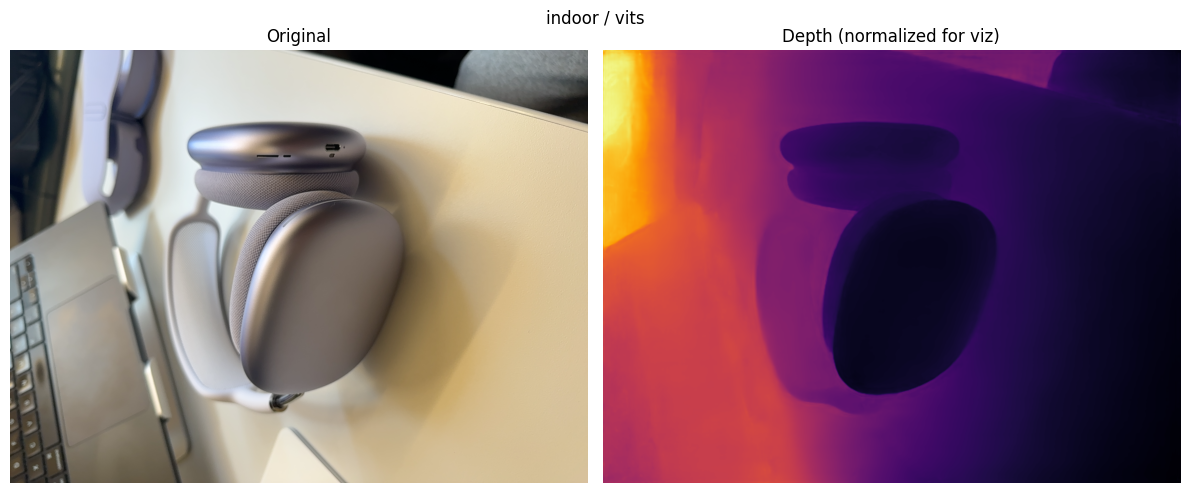

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pipeline.metric_depth import estimate_depth_metric


def load_rgb(img_path: str) -> np.ndarray:
    """OpenCV -> RGB uint8"""
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def normalize_for_viz(depth_m: np.ndarray) -> np.ndarray:
    """Normalize to [0,1] for display only."""
    d = depth_m.astype(np.float32)
    # guard against NaNs/inf and constant images
    d = np.nan_to_num(d, nan=0.0, posinf=0.0, neginf=0.0)
    dmin, dmax = float(d.min()), float(d.max())
    if dmax <= dmin + 1e-8:
        return np.zeros_like(d, dtype=np.float32)
    return (d - dmin) / (dmax - dmin)

def show_side_by_side(img_rgb: np.ndarray, depth_m: np.ndarray, title: str = ""):
    """Plot original RGB and depth heatmap side by side."""
    vis = normalize_for_viz(depth_m)
    plt.figure(figsize=(12, 5))
    # left: original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Original")
    # right: depth (normalized for display)
    plt.subplot(1, 2, 2)
    plt.imshow(vis, cmap="inferno")
    plt.axis("off")
    plt.title("Depth (normalized for viz)")
    if title:
        plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

def run_example(img_path: str, scene: str = "indoor", encoder: str = "vits"):
    # 1) load image
    rgb = load_rgb(img_path)

    # 2) estimate metric depth (meters)
    depth_m = estimate_depth_metric(
        rgb,
        scene=scene,          # 'indoor' -> Hypersim (20m) | 'outdoor' -> VKITTI (80m)
        encoder=encoder,      # 'vits' | 'vitb' | 'vitl'  (must match your checkpoint)
        checkpoints_dir="depth_anything_v2/checkpoints",
        # max_depth=None,     # override if you want a custom max
        # device=None,        # auto-picks: cuda > mps > cpu
    )

    print("Depth shape:", depth_m.shape, "dtype:", depth_m.dtype,
          f"min={depth_m.min():.3f}m, max={depth_m.max():.3f}m")

    # 3) visualize side by side
    show_side_by_side(rgb, depth_m, title=f"{scene} / {encoder}")

    # 4) (optional) save raw depth for later geometry use
    # np.save("depth_raw_meters.npy", depth_m)

# Example:
run_example(img_path=img_path, scene="indoor", encoder="vits")